<a href="https://colab.research.google.com/github/jeongmin5o/e-commerce_RFM/blob/main/%ED%8C%8C%EC%9D%B4%EB%84%90_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# read_csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/fc/파이널프로젝트')
os.getcwd()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # boxplot
import seaborn as sns # boxplot
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import re
from datetime import datetime

# 코랩 한글깨짐 방지 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
pd.set_option('display.max_columns',None) #

In [ ]:
# 데이터 불러오기 

data = pd.read_csv('차이코퍼레이션 데이터(BA_assesment).csv')
data.head()

# EDA

## **Data Dictionary**

*   2019년 8월~ 2020년 3월 (8개월)
*   **카드 사용**에 따른 **할인금액** 데이터



## 데이터 유형 변환

In [ ]:
# 데이터 개수

data.shape # (5623810, 13)

In [ ]:
# 데이터 유형

data.info()
# numeric : integer
# categorical : object
# T/F : boolean
# date : date

In [ ]:
# NA

data.isnull().sum()

In [ ]:
# 수치형 데이터 분포 

round(data.describe())

In [ ]:
# 날짜 데이터 분포 

print(min(data['created_at']))
print(max(data['created_at']))
print(min(data['birthday']))
print(max(data['birthday']))
print(min(data['sign_up_date']))
print(max(data['sign_up_date']))

In [ ]:
# 데이터 유형 변환 

data['push_permission'] = data['push_permission'].astype(str)
data['is_foreigner'] = data['is_foreigner'].astype(str)
data['customer_id'] = data['customer_id'].astype(str)
data['merchant_id'] = data['merchant_id'].astype(str)
data['created_at'] = pd.to_datetime(data['created_at'])
data['birthday'] = pd.to_datetime(data['birthday'])
data['sign_up_date'] = pd.to_datetime(data['sign_up_date'])
data.head()

In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
# 범주형 데이터 분포

data.nunique()

In [ ]:
column = data.columns
row = data.shape[0]

for i in column :
  print(i)
  print(data[i].value_counts())
  print(round(data[i].value_counts()/row*100,0))
  print('------------------------------------------------')

## 열 추가 및 삭제


**Add Variable**

|Column|weekday|cashback_rate|discount_rate|age
|--|--|--|--|--|
|**Dictionary**|요일|적립율|할인율|나이|



In [ ]:
# customer_id
# 각 결제건 groupby 해서 계산하기 위해
data['count'] = 1

In [ ]:
# created_at

data['weekday'] = data['created_at'].dt.weekday # 0: 월요일
data['weekday'].replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu',
                         4:'Fri', 5:'Sat', 6:'Sun'}, inplace=True)

# 구매 시각
data['hour'] = data['created_at'].dt.hour

# 첫 확진자 발생 2020-01-20, 사회적 거리두기 시행 2020-03-22
data['days']=data['created_at'].dt.strftime('%Y-%m-%d')

data['is_covid_A'] =  np.where(data['days']<'2020-01-20',0,1)   # 첫 확진자 발생일 이전이면 0, 이후면 1
data['is_covid_B'] = np.where(data['days']<'2020-03-22',0,1)   # 사회적 거리두기 시행 이전이면 0, 이후이면 1
# cycle = 

In [ ]:
pd.DataFrame(data.groupby(['is_covid_A','is_covid_B'])['pre_discount'].count())

In [ ]:

# post_discount 금액대별
# 최대금액 : 1996000원
data['range'] =  np.where(data['post_discount']< 10000,'under_$10',  # 1만원 미만
                                (np.where(data['post_discount']<100000 , 'under_$100',  # 10만원 미만
                                (np.where(data['post_discount']<1000000, 'under_$1000',  # 100만원 미만
                                'over_$1000')))))   #100만원 이상

data = pd.get_dummies(data, columns = ['range'])


In [ ]:
data.groupby(['gender'])[	'range_under_$10',	'range_under_$100',	'range_under_$1000', 'range_over_$1000'].sum()

In [ ]:
range = data.groupby(['days'])[	'range_under_$10',	'range_under_$100',	'range_under_$1000', 'range_over_$1000'].sum()

fig = plt.figure(figsize=(12, 12))
sns.lineplot(data = range, x = 'days',y='range_under_$10', color = 'red')
sns.lineplot(data = range, x = 'days',y='range_under_$100',color = 'blue')
sns.lineplot(data = range, x = 'days',y='range_under_$1000',color = 'green')   # 튀는 구간 존재
sns.lineplot(data = range, x = 'days',y='range_over_$1000',color = 'yellow')

# ange_under_$10 (만원이하 결제건) 는 매우 급격한 등락을 보인다. 
# 만원 이하 결제건보다 10만원 이하 결제건의 등락 폭이 좁고 안정적이다.
# range_under_$10 가 급격하게 올라가는 구간이 있다. 만원 이하 결제 건에 대한 할인 이벤트가 있었을지도 모름
# range_over_$1000은 매우 일정 (거의 없음)

In [ ]:
# cashback_amount
# 캐쉬백 할인율
data['cashback_rate'] = data['cashback_amount'] / data['pre_discount'] * 100

# 캐쉬백을 받은 사람 = 1 아닌사람 = 0
data['is_cashback'] = np.where(data['cashback_amount']==0,0,1)

In [ ]:
# discount_amount

#할인율
data['discount_rate'] = data['discount_amount'] / data['pre_discount'] * 100

# 할인을을 받은 사람 = 1 아닌사람 = 0
data['is_discount'] = np.where(data['discount_amount']==0,0,1) 

In [ ]:
range2= data.groupby(['days'])[	'is_discount'].sum()

fig = plt.figure(figsize=(8, 8))
sns.lineplot(data = range2, color = 'red')


In [ ]:
# birthday

data['age'] = data['created_at'].dt.year - data['birthday'].dt.year
data['age_category'] = (data['age'] // 10) * 10
data['age_category'] = data['age_category'].astype('object')

In [ ]:
# merchant_id

data['merchant_id'].replace({'1':'A', '2':'B', '3':'C', '4':'D', '5':'E',
                             '6':'F', '7':'G', '8':'H', '9':'I', '10':'J'}, 
                            inplace=True)

In [ ]:
# drop.merchant_id # 근거 부족 

# data.drop(columns =['merchant_id'],inplace = True)

In [ ]:
# drop.1900-01-01 # 근거 부족 

# data.drop(data[data['birthday'] == '1900-01-01'].index, inplace = True)

In [ ]:
# 첫 구매일
a = pd.DataFrame(data.groupby('customer_id')['created_at'].min()) ## 아이디로 그룹화 한다음 최근방문일을 구해야 하므로 송장날짜에 max를 적용한다.

a.rename(columns = {'created_at':'first_p_days'},inplace = True)
a.reset_index()

# 합치기
data = pd.merge(data, a, how='left',on = 'customer_id')

data.head(2)

In [ ]:
# 고객 id당 구매 횟수
counts = data['customer_id'].value_counts().to_frame()
counts = counts.reset_index().rename(columns={"index":"customer_id", "customer_id":"counts"})

data = pd.merge(data, counts, how='left', on = ['customer_id'])

In [ ]:
#전체 데이터에 count열 삽입
data['counts_g']=np.where(data['counts']==1,'one','two')
data.head(3)

In [ ]:
data.info()

In [ ]:
round(data.describe())

In [ ]:
data.isnull().sum()

In [ ]:
data.nunique()

In [ ]:
column = data.columns
row = data.shape[0]

for i in column :
  print(i)
  print(round(data[i].value_counts().describe()))
  print('------------------------------------------------')

In [ ]:
column = data.columns
row = data.shape[0]

for i in column :
  print(i)
  print(data[i].value_counts())
  print(round(data[i].value_counts()/row*100,0))
  print('------------------------------------------------')

## 데이터 분석

### 기초 분석

**Raw Data**

|Column|customer_id|created_at|pre_discount|post_discount|cashback_amount|discount_amount|total_promotion|
|--|--|--|--|--|--|--|--|
|**Dictionay**|고객식별번호|결제일시|할인 전|할인 후(결제금액)|적립금액|할인금액|총 혜택 받은 금액|
|**Dtype**|int64|object|int64|int64|int64|int64|int64|
|**Data**|1~544,921|yyyy-mm-dd hh:mm:ss.sss|1~1,996,000|0~1,996,000|0~97,473|0~500,000|0~500,000|

&

|Column|push_permission|gender|is_foreigner|birthday|sign_up_date|merchant_id|
|--|--|--|--|--|--|--|
|**Dictionay**|푸시 여부|성별|외국인 여부|생년월일|가입일시|판매자식별번호(결제채널)|
|**Dtype**|bool|object|bool|object|object|int64|
|**Data**|True/False|female/male|True/False|yyyy-mm-dd|yyyy-mm-dd hh:mm:ss.sss|1~10|

**TODO**
- 데이터 변환 
  - customer_id, push_permission, is_foreigner : Dtype to object
  - created_at,	birthday,	sign_up_date : Dtype to date
  - merchant_id : 1~ 10 -> A~ J

In [ ]:
# 0th EDA 데이터 개수

data.shape # (5623810, 13)

NameError: ignored

In [ ]:
# 0th EDA 데이터 유형

data.info()

NameError: ignored

In [ ]:
# 0th EDA 수치형 데이터 범위 

data.describe()

In [ ]:
corr = data.corr()
sns.heatmap(corr, annot=True)

In [ ]:
# 0th EDA NA

data.isnull().sum()

**Numeric Data**

|Column|pre_discount|post_discount|cashback_amount|discount_amount|total_promotion|
|--|--|--|--|--|--|
|**Dictionay**|할인 전|할인 후(결제금액)|적립금액|할인금액|총 혜택 받은 금액|
|**Dtype**|int64|int64|int64|int64|int64|int64|
|**Data**|1~1,996,000|0~1,996,000|0~97,473|0~500,000|0~500,000|

**Categorical Data**

|Column|customer_id|push_permission|gender|is_foreigner|merchant_id|
|--|--|--|--|--|--|
|**Dictionay**|고객식별번호|푸시 여부|성별|외국인 여부|판매자식별번호(결제채널)|
|**Dtype**|**object**|bool|object|bool|**object**|
|**Data**|1~544,921|True/False|female/male|True/False|**A~J**|

**Date Data**

|Column|created_at|birthday|sign_up_date|
|--|--|--|--|
|**Dictionay**|결제일시|생년월일|가입일시|
|**Dtype**|**datetime64[ns]**|**datetime64[ns]**|**datetime64[ns]**|
|**Data**|yyyy-mm-dd hh:mm:ss.sss|yyyy-mm-dd|yyyy-mm-dd hh:mm:ss.sss|

In [ ]:
# boxplot font warning solution (replay this code)

from matplotlib import font_manager
for i in font_manager.fontManager.ttflist:
    if 'Nanum' in i.name:
        print(i.name, i.fname)

import matplotlib 
matplotlib.font_manager._rebuild() 

In [ ]:
# 범주형 데이터 구성 비율

data['customer_id'].value_counts() # 인사이트 : count(결제건수) 1~2705

In [ ]:
# 결제건수가 1인 고객이 얼마나 많은가?

data['customer_id'].value_counts().describe() # 인사이트 : 결제건수가 1인 고객이 많다

NameError: ignored

In [ ]:
plt.boxplot(data['customer_id'].value_counts(), vert=False)
plt.ylabel('count')
plt.yticks(range(1), [''])

# 결제건수가 1인 고객은 분석 대상에 포함할 것인가? Yes(Need to EDA) / No(Raw Data)
# 건별(Raw Data)) / 고객별(Need to EDA)로 볼 것인가? --- Group by

In [ ]:
round(data['push_permission'].value_counts()/data.shape[0]*100,0) # 인사이트 : 푸시 52%, 비푸시 48%

In [ ]:
round(data['gender'].value_counts()/data.shape[0]*100,0) # 인사이트 : 여성 72%, 남성 28%

In [ ]:
sns.catplot(y="gender", kind="count", data=data, height=2.6, aspect=2.5, orient='h')

# https://www.kaggle.com/code/jsaguiar/exploratory-analysis-with-seaborn/notebook

In [ ]:
# 고객별 데이터
cdata = data.groupby(data['customer_id'])
cdata.head(3)

In [ ]:
# cdata = pd.DataFrame(cdata) # error
cdata.head(3)

In [ ]:
# cdata.isnull().sum() #error

In [ ]:
# 푸시 여부 비교

# def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
#     ratios = pd.DataFrame()
#     g = df.groupby(feature)["Churn"].value_counts().to_frame()
#     g = g.rename({"Churn": axis_name}, axis=1).reset_index()
#     g[axis_name] = g[axis_name]/len(df)
#     if orient == 'v':
#         ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
#         ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
#     else:
#         ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
#         ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
#     ax.plot()

In [ ]:
# barplot_percentages("SeniorCitizen")

In [ ]:
round(data['is_foreigner'].value_counts()/data.shape[0]*100,0) # 인사이트 : 내국인 99% (5561804), 외국인 1% (62006)

In [ ]:
# 외국인 1%를 분석할 데이터에 포함시킬 것인가?

data['is_foreigner'].value_counts()

In [ ]:
round(data['merchant_id'].value_counts()/data.shape[0]*100,4) # 인사이트 : A 6%, B~I 11%, J 6%

In [ ]:
# 카드 사용 비율이 같은 결제채널은 공통점이 있는가?

data['merchant_id'].value_counts()

**Categorical Data**

|Column|customer_id|push_permission|gender|is_foreigner|merchant_id|
|--|--|--|--|--|--|
|**Dictionay**|고객식별번호|푸시 여부|성별|외국인 여부|판매자식별번호(결제채널)|
|**Dtype**|object|bool|object|bool|object|
|**Data**|1~544,921|True**(52)**/False(48)|female**(72)**/male(28)|True(1)/False**(99)**|A~J|

**NA**



*   Raw Data : none
*   0th EDA Data : none
- ...



**Outlier**


*  discount_amonunt **!=** pre_discount - post_discount
*  total_promotion **!=** cashback_amount + discount_amount 
- ...
  

In [ ]:
# boxplot font warning solution (replay this code)

from matplotlib import font_manager
for i in font_manager.fontManager.ttflist:
    if 'Nanum' in i.name:
        print(i.name, i.fname)

import matplotlib 
matplotlib.font_manager._rebuild() 

In [ ]:
# boxplot

fig,ax = plt.subplots()
ax.boxplot([data['pre_discount'], data['post_discount'], data['cashback_amount'], data['discount_amount'],data['total_promotion']], vert=False)
# plt.boxplot(data['cashback_amount'], vert=False)
# plt.title('cashback_amount')
# plt.xlabel('X-Axis')
# plt.xticks(range(2), ['X-Axis', 'Y-Axis']) # 축 이름 설정
# plt.xlim([xmin, xmax]])
# plt.axis([xmin, xmax, ymin, ymax])
plt.show()

# sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips) 
  # hue 요인
# sns.boxplot(x = 'season', y = 'count', data = df, palette = 'Spectral', linewidth = 3, width = 0.5)
  # palette 색상 # linewidth 선 굵기 # width 박스 너비 

In [ ]:
data_list = ['pre_discount', 'post_discount','cashback_amount', 'discount_amount', 'total_promotion']

fig,ax = plt.subplots(len(data_list), figsize = (20,10))

for i in range(len(data_list)):
  sns.boxplot(data[data_list[i]], ax=ax[i])
  # plt.subplots(constrained_layout=True) # add plot

In [ ]:
plt.subplot(2, 1, 1) # nrows=2, ncols=1, index=1
plt.boxplot(data[data_list[1]], vert=False)
# plt.title(data_list[1])
plt.xlabel('count')
plt.ylabel(data_list[1])
plt.yticks(range(1), [''])

plt.subplot(2, 1, 2)
plt.boxplot(data[data_list[2]], vert=False)
# plt.title(data_list[2])
plt.xlabel('count')
plt.ylabel(data_list[2])
plt.yticks(range(1), [''])

# 

In [ ]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['day'] = data['created_at'].dt.strftime('%Y-%m-%d')
data.head(3)

In [ ]:
data.sort_values(by='customer_id',ascending = True)



In [ ]:
a = pd.DataFrame(data.groupby(['customer_id','day','pre_discount'])['age'].count())
a[a['age'] >1]

In [ ]:
data[(data['customer_id'] == '100') & (data['day']=='2019-10-06')]

In [ ]:
data[(data['customer_id'] == '99996') & (data['day']=='2020-01-12')&(data['pre_discount']==84600)]

In [ ]:
# pre - (discount+cash) != post
# 한 고객이 동일한 날짜에 동일한 가격으로 여러번 결제한 경우, 이상치로 혹은 취소했다가 다시 결제한 것으로 볼 수 있기 때문에 제거할 필요가 있음
arl= np.where(data['count']==1,'one','two')

qqqqq = np.where(data)

### 그래프

In [ ]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['date'] = data['created_at'].dt.strftime('%Y-%m')
data.head(3)

In [ ]:
data_date = data.groupby('date')['pre_discount', 'post_discount','cashback_amount','discount_amount','total_promotion'].sum()
data_date

In [ ]:
data.shape

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.ylabel('매출액(단위:원)', fontsize=15)
plt.title('고객 구매액',fontsize = 20)
sns.lineplot(data=data_date, x = 'date',y='pre_discount')
sns.lineplot(data=data_date, x = 'date',y='post_discount')

plt.axvline(x='2020-01', color='r', linestyle='--', linewidth=2)
plt.legend(labels = ['할인전','할인후'])

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.ylabel('할인액(단위:원)', fontsize=15)
plt.title('할인 금액', fontsize = 20)

sns.lineplot(data=data_date, x = 'date',y='cashback_amount')
sns.lineplot(data=data_date, x = 'date',y='discount_amount')
sns.lineplot(data=data_date, x = 'date',y='total_promotion')
plt.legend(labels = ['캐쉬백','할인','총할인액'])
plt.axvline(x='2020-01', color='r', linestyle='--', linewidth=2)

In [ ]:
qq = data.groupby('date')['customer_id'].count()
qq = pd.DataFrame(qq)
qq

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title("이용 건수",fontsize = 20)
sns.lineplot(data=qq, x = 'date',y='customer_id')
plt.axvline(x='2020-01', color='r', linestyle='--', linewidth=2)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.ylabel('매출액(단위:원)', fontsize=15)
sns.lineplot(data=data_date, x = 'date',y='pre_discount')
sns.lineplot(data=data_date, x = 'date',y='post_discount')

sns.lineplot(data=data_date, x = 'date',y='cashback_amount')
sns.lineplot(data=data_date, x = 'date',y='discount_amount')
sns.lineplot(data=data_date, x = 'date',y='total_promotion')
# plt.legend(labels = ['캐쉬백','할인','총할인액'])

### 고객별 비교_group by (정민)

In [ ]:
# 보유고객정보 분석
# 중복 제거된 고객 id
customer_info = data[['customer_id','gender','age','age_category','is_foreigner','push_permission']]
customer_info = customer_info.drop_duplicates(['customer_id']) # 중복제거
customers = pd.merge(counts,customer_info, on = 'customer_id',how='left')
customers.head()  

,customer_id,counts,gender,age,age_category,is_foreigner,push_permission
0,45419,2705,female,30,30,False,True
1,445691,2630,female,29,20,False,True
2,485910,1684,female,31,30,False,True
3,400418,1363,female,27,20,False,True
4,96306,1229,female,28,20,True,True


In [ ]:
customers.groupby('gender').agg({'customer_id':['count'],'counts':['sum']})

,customer_id,counts
,count,sum
gender,,
female,349482,4070077
male,195439,1553733


In [ ]:
customers.groupby('age_category').agg({'customer_id':['count'],'counts':['sum']})

,customer_id,counts
,count,sum
age_category,,
10,11371,69762
20,157279,1287118
30,226024,2256942
40,114712,1501327
50,24646,398058
60,5701,84923
70,1076,13633
80,197,2976


> 시각화

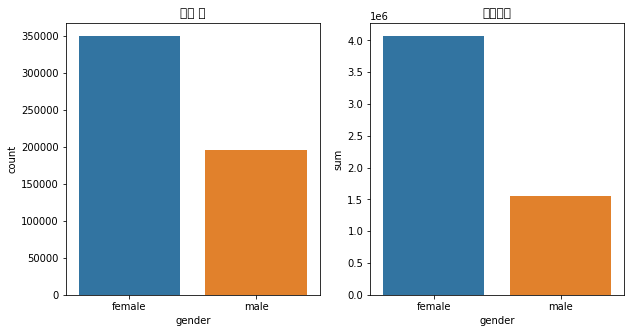

In [ ]:
# 성별에 따른 고객 수와 구매 횟수
a = customers.groupby('gender').agg({'customer_id':['count'],'counts':['sum']})
a.reset_index(inplace = True)

fig, ax = plt.subplots(1,2, figsize = (10,5) )

plt.subplot(1,2,1)
plt.title("고객 수")
sns.barplot(data = a, x = a['gender'], y = a['customer_id']['count'])

plt.subplot(1,2,2)
plt.title("구매횟수")
sns.barplot(data = a, x = a['gender'], y = a['counts']['sum'])

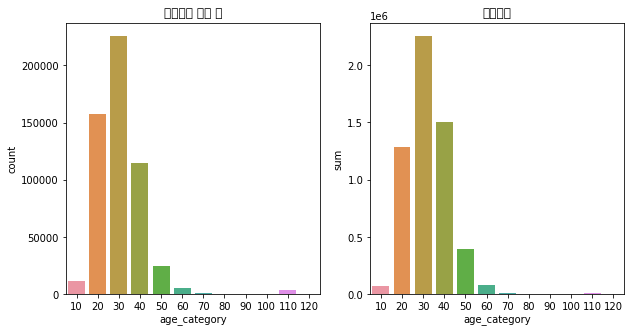

In [ ]:
# 연령대에 따른 고객 수와 구매 횟수
b = customers.groupby('age_category').agg({'customer_id':['count'],'counts':['sum']})
b.reset_index(inplace = True)

fig, ax = plt.subplots(1,2, figsize = (10,5) )


plt.subplot(1,2,1)
plt.title("연령대별 고객 수")
sns.barplot(data = b, x = b['age_category'], y = b['customer_id']['count'])

plt.subplot(1,2,2)
plt.title("구매횟수")
sns.barplot(data = b, x = b['age_category'], y = b['counts']['sum'])



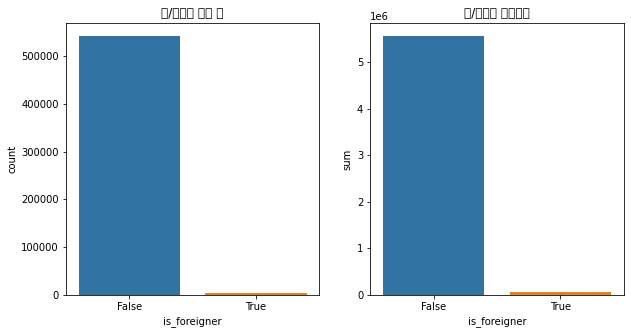

In [ ]:
#내/외국인에 따른 고객 수와 구매 횟수

c = customers.groupby('is_foreigner').agg({'customer_id':['count'],'counts':['sum']})
c.reset_index(inplace = True)

fig, ax = plt.subplots(1,2, figsize = (10,5) )


plt.subplot(1,2,1)
plt.title("내/외국인 고객 수")
sns.barplot(data = c, x ='is_foreigner', y = c['customer_id']['count'])

plt.subplot(1,2,2)
plt.title("내/외국인 구매횟수")
sns.barplot(data = c, x ='is_foreigner', y = c['counts']['sum'])



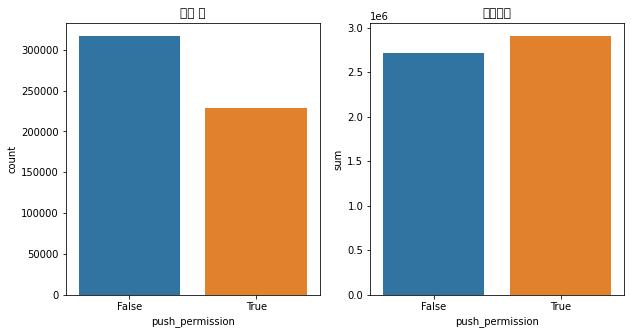

In [ ]:
#푸쉬설정에 따른 고객 수와 구매 횟수
d = customers.groupby('push_permission').agg({'customer_id':['count'],'counts':['sum']})
d.reset_index(inplace = True)

fig, ax = plt.subplots(1,2, figsize = (10,5) )


plt.subplot(1,2,1)
plt.title("고객 수")
sns.barplot(data = d, x ='push_permission', y = d['customer_id']['count'])

plt.subplot(1,2,2)
plt.title("구매횟수")
sns.barplot(data = d, x ='push_permission', y = d['counts']['sum'])



In [ ]:
# 고유수
data.nunique()
#1. 고객은 총 541,019명
#2. discount_amount와 push_permission 가 각각 1만개가 안되는 값인것을 보니, 할인의 패턴이 있는 것 같다.               

customer_id           544921
created_at           5622647
pre_discount           69956
post_discount          70516
cashback_amount         7964
discount_amount         3863
total_promotion         8577
push_permission            2
gender                     2
is_foreigner               2
birthday               19946
sign_up_date          544807
merchant_id               10
count                      1
weekday                    7
days                     244
is_covid_A                 2
is_covid_B                 2
range_over_$1000           2
range_under_$10            2
range_under_$100           2
range_under_$1000          2
cashback_rate          44005
is_cashback                2
discount_rate          86353
is_discount                2
age                       83
age_category              12
first_p_days          544900
counts                   372
counts_g                   2
dtype: int64

In [ ]:
# 1. Categorical Data
# push_permission : 푸시 o / 푸시 x

data.groupby('push_permission').agg( {'customer_id':['count'],
              'pre_discount': ['mean'], 'post_discount':['mean'], 'cashback_amount':['mean','sum'], 'discount_amount':['mean','sum'],
              'total_promotion':['mean'],  'weekday':['mean'], 'age':['mean'], 
              'first_p_days':['min','max','mean'],'cashback_rate':['mean'],'discount_rate':['mean']
    
})

> **push_permission** :알림 푸시에 따른 데이터 비교 분석

|목록| 푸쉬O ||푸쉬X|
|--|--|--|--|
|고객 수|✅|>||
|구매평균금액(할인전)||<|✅|
|구매평균금액(할인후)||<|✅|
|캐쉬백 평균금액|✅|>||
|할인받은 평균금액||<|✅|
|총 할인받은 평균금액||<|✅|
|총 할인 받은 비율(평균)|10|<|11| 
|평균 연령대|38|>|34|
|first_p_days(평균)| 26일|>|24일|


\
>**인사이트**
1. 할인 받은 평균 금액과, 총 할인받은 평균 비율이 푸쉬를 안했을 경우가 높다. 그러나, 캐쉬백의 경우 푸쉬를 한 경우가 더 높음. 캐쉬백이 푸쉬 온오프에 영향을 미친 것으로 추측됨
2. 회원가입일로부터 첫구매까지 최소 1일~ 최대 291일. 평균 24~26일 걸림.(약 한달). 생각보다 텀이 오래걸림


In [ ]:
# gender : 남성 / 여성


data.groupby('gender').agg( {'customer_id':['count'],
              'pre_discount': ['mean'], 'post_discount':['mean'], 'cashback_amount':['mean'], 'discount_amount':['mean'],
              'total_promotion':['mean'],  'weekday':['mean'], 'age':['mean'], 
              'first_p_days':['min','max','mean'],'cashback_rate':['mean'],'discount_rate':['mean'],'total_promotion_rate':['mean']
    
})


- **gender** :성별에 따른 데이터 비교 분석

|목록| 여성 ||남성|
|--|--|--|--|
|고객 수|✅|>||
|구매평균금액(할인전)|✅|>||
|구매평균금액(할인후)||<|✅|
|캐쉬백 평균금액||<|✅|
|할인받은 평균금액||<|✅|
|총 할인받은 평균금액||<|✅|
|총 할인 받은 비율(평균)|10|<|12|
|평균 연령대|35|<|38|
|first_p_days(평균)| 27일|>|21일|
 
\
> **인사이트**
1. 성별차이가 약 3배가 남. 여성의 비율이 매우 높음|
2. 가입일로부터 첫구매까지6일이나 차이가 남. 약 1주일의 기간으로 생각보다 많이 차이나는 것으로 보임
3. 구매 평균금액이 여성의 경우가 높으나, 총 할인 받은 금액의 비율이 남성이 높음. 즉, 구매 금액 대비 남성이 더 높은 할인 혜택을 받은 것을 알 수 있다.

In [ ]:
# is_foreigner : 내국인 / 외국인


data.groupby('is_foreigner').agg( {'customer_id':['count'],
              'pre_discount': ['mean'], 'post_discount':['mean'], 'cashback_amount':['mean'], 'discount_amount':['mean'],
              'total_promotion':['mean'],  'weekday':['mean'], 'age':['mean'], 
              'first_p_days':['min','max','mean'],'cashback_rate':['mean'],'discount_rate':['mean'],'total_promotion_rate':['mean']
    
})


- **is_foreigner** :내/외국인에 따른 데이터 비교 분석

|목록| 내국인 ||외국인|
|--|--|--|--|
|고객 수|✅|>||
|구매평균금액(할인전)|✅|>||
|구매평균금액(할인후)|✅|>||
|캐쉬백 평균금액||<|✅|
|할인받은 평균금액|✅|>||
|총 할인받은 평균금액|✅|>||
|총 할인 받은 비율(평균)|✅|>||
|평균 연령대|36|>|32|
|first_p_days(평균)| 25일|>|27일|
 
\
> 인사이트
1. 외국인의 캐쉬백 받는 평균금액이 내국인보다 높다!
2. 캐쉬백 혜택이 외국인에게 좀 더 많은 혜택을 주는지 혹은 외국인이 사용하기 편리한 것이 캐쉬백인지는 알 수 없다


In [ ]:
#나이대별
data['age_category'] = data['age_category'].astype(int)
data.groupby('age_category').agg( {'customer_id':['count'],
              'pre_discount': ['mean','sum'], 'post_discount':['mean'], 'cashback_amount':['mean'], 'discount_amount':['mean'],
              'total_promotion':['mean'],  
              'first_p_days':['min','max','mean'],'cashback_rate':['mean'],'discount_rate':['mean'],'total_promotion_rate':['mean']
    
}).sort_values(by='age_category',ascending=True)



> 인사이트
1. 연령분포가 20~30대에 몰려있다
2. 평균 구매 금액과 총 할인받은 비율이 70대가 가장 높다. 모수가 적어서 이러한 결과가 나온 것으로 판단된다.
3. 할인 전 총 구매 금액은 30대가 가장 높다(모수가 많은 만큼, 높을 수 밖에 없음)


100세의 경우, 회원 가입 후 결제까지 텀이 2분밖에 되지 않는다. 매우 이상함... 100세는 제거하고 보는게 맞을 것 같다.

### 1건 구매 vs 여러 건 구매 고객별 비교(정민)


In [ ]:
# 1번 구매한 사람, 1번 이상 구매한 사람 두 그룹으로 나누어 비교
arl= np.where(data['counts']==1,'one','two')
ww = data.groupby(arl, axis=0).mean()
ww.reset_index(inplace = True)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.ylabel('매출액(단위:원)', fontsize=15)
plt.title('할인받은 비율(total_promotion_rate)',fontsize = 20)
sns.barplot(data=ww, x = 'index',y='total_promotion_rate')


- 구매 평균 가격이 1번 구매 한 사람이 더 높다.(모수때문인듯..?)
- 여기서 주목할 점은! 1번 구매한 사람은 2번 이상 구매한 사람보다 **할인**을 많이 받은 반면, **캐쉬백은 2번이상 구매한 사람이 더 많이 받았다.** 
- 결과적으로, 2번 이상 구매한 사람이 첫 구매한 사람보다 평균 총 할인 비율이 7퍼센트 적다. **첫 구매 할인이 매우 큰 것으로 보임**

In [ ]:
# push_permission : 푸시 o / 푸시 x

#1건 구매
data.groupby(['counts_g','push_permission']).agg( {'customer_id':['count'],
              'pre_discount': ['mean'], 'post_discount':['mean'], 'cashback_amount':['mean','sum'], 'discount_amount':['mean','sum'],
              'total_promotion':['mean'], 'age':['mean'], 
              'first_p_days':['min','max','mean'],'cashback_rate':['mean'],'discount_rate':['mean']
    
})

>푸쉬 온/오프 **인사이트**

1. 1번 구매한 사람은 **푸쉬를 안한 사람**의 비중과 할인 받은 총 금액이 더 높다.
  그러나, 2번 이상 구매한 사람은**푸쉬를 한 사람**의 비중과 할인 받은 총금액이 더 높다
2. 평균적으로 두번 이상 구매한 사람이 회원 가입 부터 첫구매까지 걸리는 일수가 적다

1.   두번 이상 구매한 사람의 **캐쉬백** 받은 비율이 더 높다( 약 0.4% ) 
2.   그러나, 두번 이상 구매한 사람의**할인 받은 비율**과 총 할인받은 비율이 더 낮다 ( 약 7%) 
2.   즉, **첫 구매당시 할일율이 매우 높음을 알 수 있다.**



In [ ]:
# 성별

#1건 구매
data.groupby(['gender','counts_g']).agg( {'customer_id':['count'],
              'pre_discount': ['mean'], 'post_discount':['mean'], 'cashback_amount':['mean','sum'], 'discount_amount':['sum','mean'],
              'total_promotion':['mean','sum'], 'age':['mean'], 
              'first_p_days':['min','max','mean'],'cashback_rate':['mean'],'discount_rate':['mean']
    
})

> 성별 **인사이트**



1.   가장 많이 차이가 나는 부분은, 1번 구매한 손님의 캐쉬백 할인 금액이다.
    남성이 여성보다 평균적으로 2배 더 많은 캐쉬백을 받았다.
2. 여성의 평균 연령이 남성보다 낮다
3. first_p_days 가 여성이 평균 기간이 더 길다. 특히, 1번 구매한 여성의 기간이 제일 길다.
4. 캐쉬백은 성별에 따른 유의미한 차이가 없다
5. 총 할인 비율 또한 큰 차이가 없으나, 여성이 남성보다 적은 할인 비율을 보인다.




In [ ]:
# 내/외국인

#1건 구매
data.groupby(['counts_g','is_foreigner']).agg( {'customer_id':['count'],
              'pre_discount': ['mean'], 'cashback_amount':['mean'], 'discount_amount':['mean'],
              'total_promotion':['mean'], 'cashback_rate':['mean'],'discount_rate':['mean'],
              'age':['mean'], 'first_p_days':['min','max','mean']
    
})

> 내/외국인 **인사이트**

1. 외국인의 경우, 2번 이상 구매한 사람이 1번 구매한 사람보다 많다

In [ ]:
#나이대별

data.groupby(['age_category','counts_g']).agg( {'customer_id':['count'],
              'pre_discount': ['mean','sum'], 'post_discount':['mean'], 'cashback_amount':['mean'], 'discount_amount':['mean'],
              'total_promotion':['mean'],  
              'first_p_days':['min','max','mean'],'cashback_rate':['mean'],'discount_rate':['mean']
    
}).sort_values(by='age_category',ascending=True)

1. 전 연령대가 2번 이상 구매한 횟수가 1번 구매한 횟수보다 많다
2. 전체적으로 모수가 너무 많은 차이가 나서 평균으로 비교하기 어려움

### 8월 17일 (희구)


In [ ]:
# 결제 금액이 0원
data[data.post_discount == 0]

In [ ]:
# 결제 금액이 0원인 사람 중 PUSH 알람 유무 성별 수
data[data.post_discount == 0].groupby(['push_permission'])['gender'].value_counts()

In [ ]:
# 결제 금액이 0원인 사람 중 PUSH 알람 유무 내외국인 수
data[data.post_discount == 0].groupby(['push_permission'])['is_foreigner'].value_counts()

In [ ]:
#결제 금액이 0원인 사람의 성별 내외국인 수
data[data.post_discount == 0].groupby(['gender'])['is_foreigner'].value_counts()

In [ ]:
# 결제건이 0원이 아닌 
data[data.post_discount != 0]

In [ ]:
data[data.post_discount != 0].groupby(['push_permission'])['gender'].value_counts()

In [ ]:
data[data.post_discount != 0].groupby(['push_permission'])['is_foreigner'].value_counts()

In [ ]:
data[data.post_discount != 0].groupby(['gender'])['is_foreigner'].value_counts()

In [ ]:
data[data.post_discount != 0].groupby(['age'])['gender'].value_counts()

In [ ]:
data[data.post_discount == 0].groupby('age_category')['gender'].value_counts()

In [ ]:
data[data.post_discount != 0].groupby(['age_category'])['gender'].value_counts()

**결제 금액 0원 VS 1원 이상 인사이트**
1. 0원 결제 금액보다 압도적으로 0원이 아닌 결제 내역이 더 많다.
2. 0원이 아닌 결제 금액 사람들의 푸시 알람 유무가 많이 차이 나지 않는다.
3. 0원이 결제 금액 사람들에서는 푸시 알람 유무가 두 배차이로 하지 않은 사람들이 더 많다.
4. 0원 결제 사람들의 나이대와 성별은 30대 남성과 30대 여성이 많고
비교적 남성 고객 비율이 높다
5. 0원이 아닌 결제 사람들의 나이대와 성별은 30대 여성이 많고 비교적 여성 고객들의 비율이 많이 나온다.


#8월 22일 (희구)

In [ ]:
data

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g
0,207317,2020-03-22 10:27:52.498,36236,36236,1087,0,1087,True,female,False,1957-11-05,2019-11-30 16:48:19.339,I,1,Sun,2020-03-22,1,1,0,0,1,0,2.999779,1,0.000000,0,63,60,2019-12-02 00:47:53.608,13,two
1,95246,2020-03-12 09:41:09.845,12900,12900,387,0,387,True,female,False,1983-10-23,2019-07-09 08:21:14.098,F,1,Thu,2020-03-12,1,0,0,0,1,0,3.000000,1,0.000000,0,37,30,2020-01-02 11:22:49.008,20,two
2,208074,2020-02-01 08:54:53.246,7500,7500,225,0,225,True,female,False,1975-07-06,2019-08-15 01:02:13.336,I,1,Sat,2020-02-01,1,0,0,1,0,0,3.000000,1,0.000000,0,45,40,2019-08-15 01:04:53.750,47,two
3,15552,2020-03-06 10:23:21.183,11800,11800,354,0,354,False,male,False,1996-08-21,2019-08-06 02:09:28.712,D,1,Fri,2020-03-06,1,0,0,0,1,0,3.000000,1,0.000000,0,24,20,2019-08-26 07:28:54.224,24,two
4,511595,2020-03-13 12:00:27.914,29700,29700,891,0,891,True,female,False,1999-01-23,2020-03-12 00:33:46.147,E,1,Fri,2020-03-13,1,0,0,0,1,0,3.000000,1,0.000000,0,21,20,2020-03-12 00:32:37.555,3,two
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5623805,434398,2019-12-12 07:48:51.491,7547,7547,0,0,0,True,female,False,1975-02-06,2019-06-17 11:09:42.453,E,1,Thu,2019-12-12,0,0,0,1,0,0,0.000000,0,0.000000,0,44,40,2019-08-01 11:54:13.514,136,two
5623806,481515,2019-12-20 07:37:15.259,22900,20900,0,2000,2000,True,female,False,1989-01-23,2019-08-22 01:26:58.339,B,1,Fri,2019-12-20,0,0,0,0,1,0,0.000000,0,8.733624,1,30,30,2019-08-22 01:31:10.257,40,two
5623807,298192,2020-01-05 01:55:28.331,19790,18790,0,1000,1000,True,female,False,1985-04-06,2019-09-13 17:15:21.732,A,1,Sun,2020-01-05,0,0,0,0,1,0,0.000000,0,5.053057,1,35,30,2019-09-18 11:52:30.099,13,two
5623808,430962,2019-10-01 03:32:17.435,15921,14152,0,1769,1769,False,male,False,1983-07-25,2019-06-20 00:59:09.309,C,1,Tue,2019-10-01,0,0,0,0,1,0,0.000000,0,11.111111,1,36,30,2019-08-01 10:10:04.725,18,two


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5623810 entries, 0 to 5623809
Data columns (total 31 columns):
 #   Column             Dtype         
---  ------             -----         
 0   customer_id        object        
 1   created_at         datetime64[ns]
 2   pre_discount       int64         
 3   post_discount      int64         
 4   cashback_amount    int64         
 5   discount_amount    int64         
 6   total_promotion    int64         
 7   push_permission    object        
 8   gender             object        
 9   is_foreigner       object        
 10  birthday           datetime64[ns]
 11  sign_up_date       datetime64[ns]
 12  merchant_id        object        
 13  count              int64         
 14  weekday            object        
 15  days               object        
 16  is_covid_A         int64         
 17  is_covid_B         int64         
 18  range_over_$1000   uint8         
 19  range_under_$10    uint8         
 20  range_under_$100   uint8

**중복 결제건 특징**

In [ ]:
data[data.created_at == '2020-01-30 00:12:06.592']

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g
1238736,228664,2020-01-30 00:12:06.592,5900,3900,0,2000,2000,True,female,False,1984-08-20,2020-01-09 00:32:35.541,C,1,Thu,2020-01-30,1,0,0,1,0,0,0.0,0,33.898305,1,36,30,2020-01-09 00:38:29.486,47,two
4423814,31439,2020-01-30 00:12:06.592,3500,1500,0,2000,2000,False,male,False,1982-08-04,2019-08-01 09:14:56.987,C,1,Thu,2020-01-30,1,0,0,1,0,0,0.0,0,57.142857,1,38,30,2019-08-01 10:34:13.309,26,two
5273866,321088,2020-01-30 00:12:06.592,4500,2500,0,2000,2000,True,female,False,1980-08-24,2019-12-03 21:35:03.458,C,1,Thu,2020-01-30,1,0,0,1,0,0,0.0,0,44.444444,1,40,40,2019-12-03 23:24:17.316,36,two


In [ ]:
data[data.created_at == '2019-09-06 00:31:40.500']

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g
1221640,13082,2019-09-06 00:31:40.500,10220,9085,0,1135,1135,False,female,False,1995-08-20,2019-08-07 02:26:15.949,C,1,Fri,2019-09-06,0,0,0,1,0,0,0.0,0,11.105675,1,24,20,2019-08-07 02:28:08.061,53,two
2307875,351824,2019-09-06 00:31:40.500,11601,10312,0,1289,1289,False,female,False,1987-01-18,2019-08-01 21:46:23.254,I,1,Fri,2019-09-06,0,0,0,0,1,0,0.0,0,11.111111,1,32,30,2019-08-01 21:48:33.236,64,two


In [ ]:
# 1원 상품을 결제한 고객의 특징은?
#len(data[data.post_discount == 1 ])
data[(data.post_discount == 1)]

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g
891990,5803,2020-01-01 10:08:18.239,1,1,0,0,0,True,female,False,1974-04-20,2019-09-01 09:53:34.084,D,1,Wed,2020-01-01,0,0,0,1,0,0,0.0,0,0.000000,0,46,40,2019-09-01 10:21:54.958,10,two
1187465,59464,2019-11-14 15:52:28.075,5001,1,0,5000,5000,True,male,False,1981-12-06,2019-09-25 07:32:06.004,J,1,Thu,2019-11-14,0,0,0,1,0,0,0.0,0,99.980004,1,38,30,2019-11-14 15:52:28.075,12,two
1473931,182621,2020-01-02 10:02:15.749,1,1,0,0,0,False,male,False,1987-06-10,2019-09-18 06:49:44.589,H,1,Thu,2020-01-02,0,0,0,1,0,0,0.0,0,0.000000,0,33,30,2019-09-18 06:48:43.231,50,two
2485524,516287,2019-09-01 13:38:48.548,1,1,0,0,0,True,female,True,1985-12-19,2019-06-14 14:42:09.367,B,1,Sun,2019-09-01,0,0,0,1,0,0,0.0,0,0.000000,0,34,30,2019-08-01 10:01:57.442,123,two
3300189,183000,2019-08-18 16:00:17.652,1,1,0,0,0,True,female,False,1969-08-14,2019-06-18 10:29:49.701,F,1,Sun,2019-08-18,0,0,0,1,0,0,0.0,0,0.000000,0,50,50,2019-08-01 21:28:09.799,42,two
3321496,301137,2020-01-02 15:28:34.414,1,1,0,0,0,False,male,False,1986-01-14,2019-11-16 14:58:43.240,G,1,Thu,2020-01-02,0,0,0,1,0,0,0.0,0,0.000000,0,34,30,2020-01-02 15:28:34.414,8,two
3709854,276138,2019-09-30 13:29:54.215,1,1,0,0,0,True,female,False,1971-02-17,2019-08-12 11:14:26.362,F,1,Mon,2019-09-30,0,0,0,1,0,0,0.0,0,0.000000,0,48,40,2019-08-12 11:37:28.064,90,two
3792912,449183,2020-02-02 14:40:43.995,1,1,0,0,0,True,female,False,1983-12-19,2019-09-06 16:43:52.091,I,1,Sun,2020-02-02,1,0,0,1,0,0,0.0,0,0.000000,0,37,30,2019-09-06 16:48:28.078,51,two
4022413,157571,2019-08-01 01:31:41.042,5001,1,0,5000,5000,True,male,False,1981-12-04,2019-06-21 10:05:03.783,I,1,Thu,2019-08-01,0,0,0,1,0,0,0.0,0,99.980004,1,38,30,2019-08-01 01:31:41.042,158,two
4028749,110452,2019-09-30 22:22:18.099,1,1,0,0,0,False,female,False,1996-01-20,2019-06-14 00:41:37.412,I,1,Mon,2019-09-30,0,0,0,1,0,0,0.0,0,0.000000,0,23,20,2019-08-02 09:24:35.372,83,two


In [ ]:
#1,996,000원 상품을 결제
data[(data.post_discount == 1996000)]

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g
3132474,273470,2020-02-04 10:30:55.832,1996000,1996000,59880,0,59880,True,female,False,1981-11-13,2019-11-15 18:34:30.427,H,1,Tue,2020-02-04,1,0,1,0,0,0,3.0,1,0.0,0,39,30,2019-11-19 11:38:01.819,22,two


In [ ]:
# 0원원 상품 결제
data[(data.post_discount == 0)].groupby('push_permission')['age_category'].value_counts()


push_permission  age_category
False            30              3030
                 20              1382
                 40               988
                 110              190
                 50               180
                 60               100
                 10                46
                 70                29
                 80                 6
                 90                 1
                 100                1
True             30              1351
                 40               763
                 20               551
                 50               150
                 60                72
                 110               57
                 10                45
                 70                29
                 80                 2
Name: age_category, dtype: int64

In [ ]:
# 캐쉬백 97,473 결제건 특징
data[data.cashback_amount == 97473]

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g
613096,106823,2020-02-19 18:21:17.422,1949490,1949490,97473,0,97473,False,female,False,1986-05-15,2019-07-09 13:02:28.524,F,1,Wed,2020-02-19,1,0,1,0,0,0,4.999923,1,0.0,0,34,30,2019-09-15 10:16:05.324,14,two


In [ ]:
# 캐쉬백 여부
data[(data.cashback_amount == 0) & (data.age_category == 60)]

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g
4159,366457,2019-08-26 11:34:07.501,14500,11500,0,3000,3000,True,male,False,1956-01-16,2019-06-14 13:57:17.696,J,1,Mon,2019-08-26,0,0,0,0,1,0,0.0,0,20.689655,1,63,60,2019-08-04 09:41:53.223,145,two
4174,353156,2019-12-20 12:09:47.117,18700,17700,0,1000,1000,True,male,False,1959-07-13,2019-08-26 12:04:05.596,E,1,Fri,2019-12-20,0,0,0,0,1,0,0.0,0,5.347594,1,60,60,2019-08-26 12:02:53.095,52,two
4294,386175,2019-12-25 23:22:52.864,935000,915000,0,20000,20000,False,female,False,1956-05-02,2019-08-01 18:48:16.218,B,1,Wed,2019-12-25,0,0,0,0,0,1,0.0,0,2.139037,1,63,60,2019-08-01 18:50:38.746,25,two
4395,350417,2019-11-04 10:03:44.493,6741,5992,0,749,749,True,male,False,1959-06-25,2019-06-13 15:50:55.025,C,1,Mon,2019-11-04,0,0,0,1,0,0,0.0,0,11.111111,1,60,60,2019-08-01 04:28:18.982,82,two
4465,301236,2020-01-01 01:05:53.736,10800,9800,0,1000,1000,True,female,False,1952-02-18,2019-12-08 22:19:16.557,B,1,Wed,2020-01-01,0,0,0,1,0,0,0.0,0,9.259259,1,68,60,2019-12-08 22:17:19.287,86,two
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5623692,240428,2019-10-21 03:21:08.452,935000,905000,0,30000,30000,True,female,False,1959-11-29,2019-08-01 22:00:04.860,H,1,Mon,2019-10-21,0,0,0,0,0,1,0.0,0,3.208556,1,60,60,2019-08-01 22:12:58.384,55,two
5623708,285654,2019-08-26 20:24:58.172,7500,4500,0,3000,3000,True,male,False,1959-10-06,2019-07-24 23:41:05.653,J,1,Mon,2019-08-26,0,0,0,1,0,0,0.0,0,40.000000,1,60,60,2019-08-06 20:23:57.767,12,two
5623711,190494,2020-01-27 09:41:16.198,3900,1900,0,2000,2000,True,female,False,1951-12-19,2019-07-01 12:48:39.412,B,1,Mon,2020-01-27,1,0,0,1,0,0,0.0,0,51.282051,1,69,60,2019-09-30 07:32:06.385,31,two
5623770,362266,2019-10-21 22:14:10.017,4073,3621,0,452,452,False,male,False,1952-03-08,2019-08-12 19:30:20.129,B,1,Mon,2019-10-21,0,0,0,1,0,0,0.0,0,11.097471,1,67,60,2019-08-12 21:58:38.545,5,two


In [ ]:
# discount_amount = 500000
data[data.discount_amount == 500000 ]

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,hour,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g,cashback_category
3137949,276087,2019-09-04 20:41:57.177,1348280,848280,0,500000,500000,True,male,False,1982-03-23,2019-06-04 17:41:01.322,I,1,Wed,20,2019-09-04,0,0,0,0,0,1,0.0,0,37.084285,1,37,30,2019-08-01 23:25:56.135,2,two,0.0
5368219,177212,2019-12-14 11:29:32.242,1154400,654400,0,500000,500000,True,male,True,1989-04-22,2019-05-29 18:26:59.748,G,1,Sat,11,2019-12-14,0,0,0,0,0,1,0.0,0,43.312543,1,30,30,2019-08-01 23:17:24.451,35,two,0.0


In [ ]:
# discount_amount = 0 
data[(data.discount_amount == 0) & (data.gender == 'female') ]

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,hour,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g,cashback_category
0,207317,2020-03-22 10:27:52.498,36236,36236,1087,0,1087,True,female,False,1957-11-05,2019-11-30 16:48:19.339,I,1,Sun,10,2020-03-22,1,1,0,0,1,0,2.999779,1,0.0,0,63,60,2019-12-02 00:47:53.608,13,two,2.0
1,95246,2020-03-12 09:41:09.845,12900,12900,387,0,387,True,female,False,1983-10-23,2019-07-09 08:21:14.098,F,1,Thu,9,2020-03-12,1,0,0,0,1,0,3.000000,1,0.0,0,37,30,2020-01-02 11:22:49.008,20,two,3.0
2,208074,2020-02-01 08:54:53.246,7500,7500,225,0,225,True,female,False,1975-07-06,2019-08-15 01:02:13.336,I,1,Sat,8,2020-02-01,1,0,0,1,0,0,3.000000,1,0.0,0,45,40,2019-08-15 01:04:53.750,47,two,3.0
4,511595,2020-03-13 12:00:27.914,29700,29700,891,0,891,True,female,False,1999-01-23,2020-03-12 00:33:46.147,E,1,Fri,12,2020-03-13,1,0,0,0,1,0,3.000000,1,0.0,0,21,20,2020-03-12 00:32:37.555,3,two,3.0
5,542961,2020-03-02 19:32:27.893,30900,30900,927,0,927,False,female,False,1979-08-12,2019-06-27 11:38:07.948,B,1,Mon,19,2020-03-02,1,0,0,0,1,0,3.000000,1,0.0,0,41,40,2019-10-23 14:37:11.456,7,two,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5623769,475844,2020-01-10 16:26:53.756,5780,5780,0,0,0,False,female,False,1982-02-18,2019-11-19 10:59:08.411,C,1,Fri,16,2020-01-10,0,0,0,1,0,0,0.000000,0,0.0,0,38,30,2019-11-19 10:45:13.018,61,two,0.0
5623795,95339,2020-01-17 22:32:50.242,6900,6900,0,0,0,True,female,False,1990-03-02,2019-07-31 21:22:40.447,H,1,Fri,22,2020-01-17,0,0,0,1,0,0,0.000000,0,0.0,0,30,30,2019-08-01 12:55:18.974,13,two,0.0
5623796,159782,2019-12-28 15:30:14.589,9800,9800,0,0,0,False,female,False,1972-06-08,2019-06-13 01:17:24.265,I,1,Sat,15,2019-12-28,0,0,0,1,0,0,0.000000,0,0.0,0,47,40,2019-08-02 09:03:15.674,32,two,0.0
5623799,363365,2020-03-07 22:45:14.105,1980,1980,0,0,0,False,female,False,1993-01-09,2019-06-15 03:47:15.931,F,1,Sat,22,2020-03-07,1,0,0,1,0,0,0.000000,0,0.0,0,27,20,2019-08-03 14:11:56.203,332,two,0.0


In [ ]:
# 할인율 범주
data['cashback_category'] = (data['cashback_rate'] // 1) 
data['cashback_category'] = data['cashback_category'].astype('object')

In [ ]:
data[(data.cashback_category == 3) & (data.push_permission == 'True')]

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id,count,weekday,hour,days,is_covid_A,is_covid_B,range_over_$1000,range_under_$10,range_under_$100,range_under_$1000,cashback_rate,is_cashback,discount_rate,is_discount,age,age_category,first_p_days,counts,counts_g,cashback_category
1,95246,2020-03-12 09:41:09.845,12900,12900,387,0,387,True,female,False,1983-10-23,2019-07-09 08:21:14.098,F,1,Thu,9,2020-03-12,1,0,0,0,1,0,3.0,1,0.000000,0,37,30,2020-01-02 11:22:49.008,20,two,3.0
2,208074,2020-02-01 08:54:53.246,7500,7500,225,0,225,True,female,False,1975-07-06,2019-08-15 01:02:13.336,I,1,Sat,8,2020-02-01,1,0,0,1,0,0,3.0,1,0.000000,0,45,40,2019-08-15 01:04:53.750,47,two,3.0
4,511595,2020-03-13 12:00:27.914,29700,29700,891,0,891,True,female,False,1999-01-23,2020-03-12 00:33:46.147,E,1,Fri,12,2020-03-13,1,0,0,0,1,0,3.0,1,0.000000,0,21,20,2020-03-12 00:32:37.555,3,two,3.0
16,336066,2020-02-18 00:47:37.611,27300,25300,819,2000,2819,True,female,False,1995-04-08,2019-10-02 21:22:17.021,H,1,Tue,0,2020-02-18,1,0,0,0,1,0,3.0,1,7.326007,1,25,20,2019-11-02 00:36:49.837,3,two,3.0
17,430307,2020-03-02 10:01:24.787,11800,11800,354,0,354,True,female,False,1973-04-16,2020-03-02 04:59:05.557,B,1,Mon,10,2020-03-02,1,0,0,0,1,0,3.0,1,0.000000,0,47,40,2020-03-02 04:57:49.043,13,two,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5605931,29276,2020-02-06 15:23:03.010,17800,17800,534,0,534,True,male,False,1975-08-02,2019-12-10 22:03:19.785,H,1,Thu,15,2020-02-06,1,0,0,0,1,0,3.0,1,0.000000,0,45,40,2019-12-10 22:01:16.767,26,two,3.0
5605933,454640,2020-03-10 00:42:15.129,48400,48400,1452,0,1452,True,female,False,1978-07-27,2019-08-02 12:39:18.976,E,1,Tue,0,2020-03-10,1,0,0,0,1,0,3.0,1,0.000000,0,42,40,2019-08-02 12:47:42.485,90,two,3.0
5605935,220213,2020-02-12 14:02:46.840,5900,5900,177,0,177,True,female,False,1983-03-30,2019-06-17 14:42:59.301,B,1,Wed,14,2020-02-12,1,0,0,1,0,0,3.0,1,0.000000,0,37,30,2019-08-01 21:16:52.847,180,two,3.0
5605936,442611,2020-03-08 18:53:52.445,26900,26900,807,0,807,True,male,False,1989-06-06,2019-11-29 21:01:30.228,C,1,Sun,18,2020-03-08,1,0,0,0,1,0,3.0,1,0.000000,0,31,30,2019-12-16 13:16:35.623,10,two,3.0


# LTV(승우)

## 재구매율 - cohort analysis

In [ ]:
# 컬럼 소개 year = 구매한 달, month = 구매 년-월, MonthStarted = 첫 구매달, MonthPassed = 첫 구매로부터 지난 개월 수

data['year'] = data['created_at'].dt.to_period(freq='A')
data['month'] = data['created_at'].dt.to_period(freq='M')

month_group = data.groupby('customer_id')['month']
data['MonthStarted'] = month_group.transform(np.min)

data['MonthPassed'] = (data['month'].dt.year - data['MonthStarted'].dt.year) * 12 + \
    (data['month'].dt.month - data['MonthStarted'].dt.month)

In [ ]:
data.head()

In [ ]:
# 첫구매 년-월로 결제자들 그룹화해서 시간에 따른(개월수 기준) 재구매율 확인하기

def get_unique_no(x):
    return len(np.unique(x))

cohort_group = data.groupby(['MonthStarted', 'MonthPassed'])
cohort_df = cohort_group['customer_id'].apply(get_unique_no).reset_index()

cohort_df = cohort_df.pivot(index='MonthStarted', columns='MonthPassed')

customer_cohort = cohort_df.div(cohort_df.iloc[:, 0], axis=0) * 100
customer_cohort = customer_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
sns.heatmap(customer_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

## 재구매율 - customer analysis

In [ ]:
# 전체 데이터로부터 고객 당 최초 구매, 마지막 구매, 구매횟수를 구해 테이블을 만들어보자..
first = pd.DataFrame(data.groupby('customer_id')['created_at'].min()) # 최초 구매
last = pd.DataFrame(data.groupby('customer_id')['created_at'].max()) # 마지막 구매
buy_ct = pd.DataFrame(data.groupby('customer_id')['created_at'].count()) # 구매횟수
rebuy= pd.concat([first,last],axis=1) # 테이블 병합
rebuy = pd.concat([rebuy,buy_ct], axis=1)
rebuy.columns = ['first','last','buy_ct']
rebuy

In [ ]:
# first, last컬럼이 datetime타입이 아니라면 실행
rebuy['first'] = pd.to_datetime(rebuy['first'])
rebuy['last'] = pd.to_datetime(rebuy['last'])

In [ ]:
rebuy['term'] = rebuy['last'] - rebuy['first'] # 전체 구매 기간
rebuy['term'] = rebuy['term'].apply(lambda x : x.days) # 일자만 보이게 세팅

# 구매주기 구하기
# 구매기간 / (구매횟수 -1) 이라서 대략적인 구매주기이다, 정확한 구매주기는 아님
rebuy['cycle'] = rebuy['term']/(rebuy['buy_ct']-1)
rebuy['cycle'] = rebuy['cycle'].fillna(0)
rebuy

# 재구매 heat-map으로 보기

## 성별

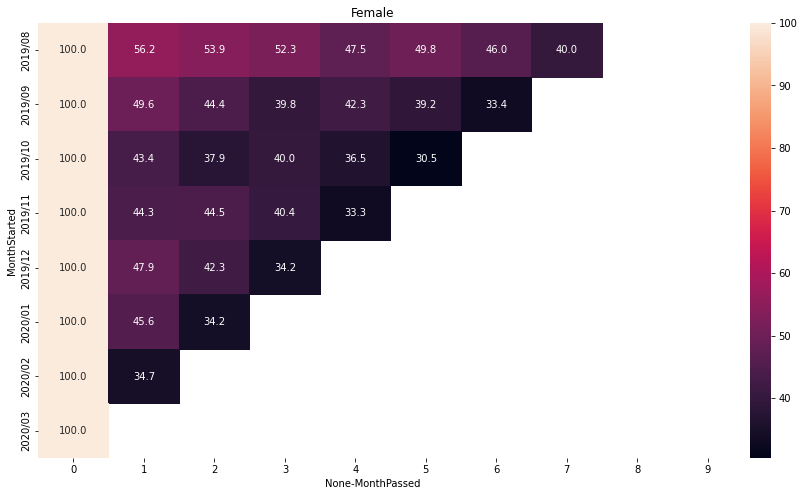

In [ ]:
# 여성 그룹
female_dt = data[data['gender'] == 'female']
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('Female')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

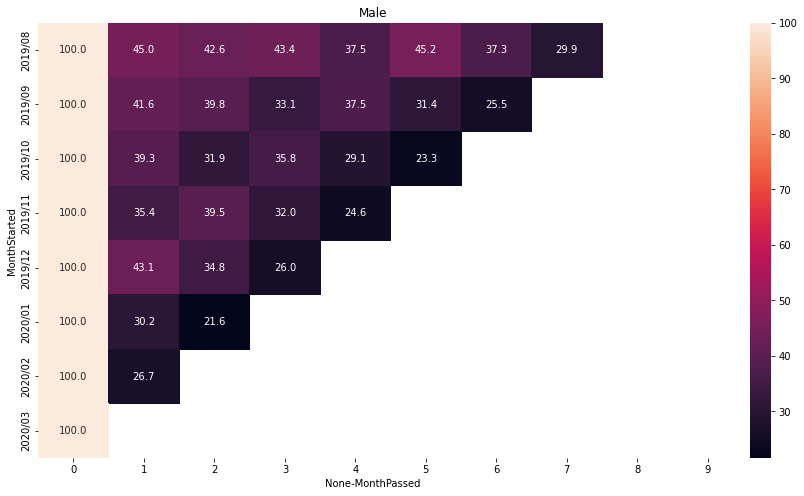

In [ ]:
# 남성 그룹
female_dt = data[data['gender'] == 'male']
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('Male')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

## 연령

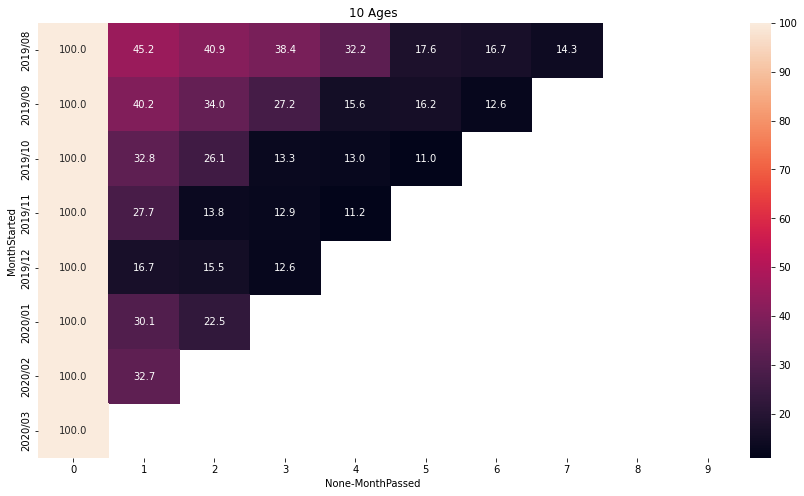

In [ ]:
female_dt = data[data['age_category'] == 10]
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('10 Ages')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

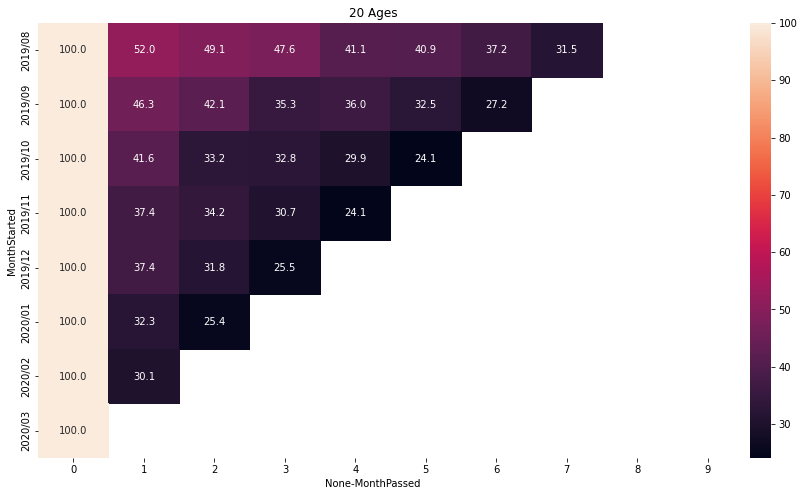

In [ ]:
female_dt = data[data['age_category'] == 20]
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('20 Ages')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

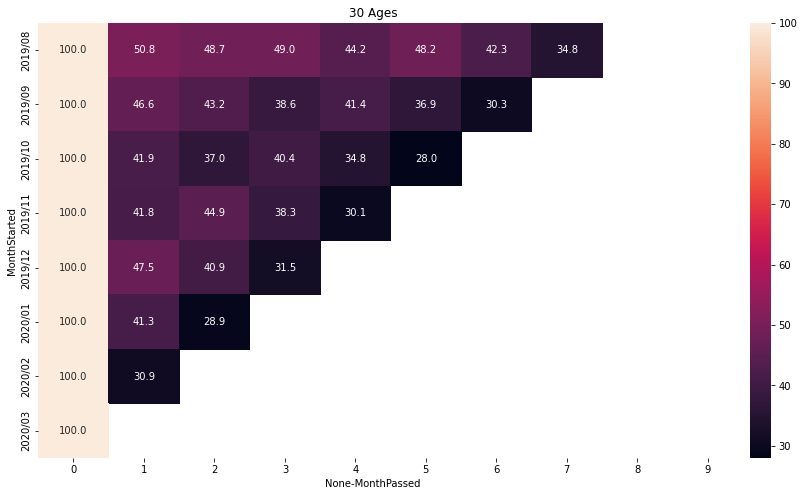

In [ ]:
female_dt = data[data['age_category'] == 30]
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('30 Ages')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

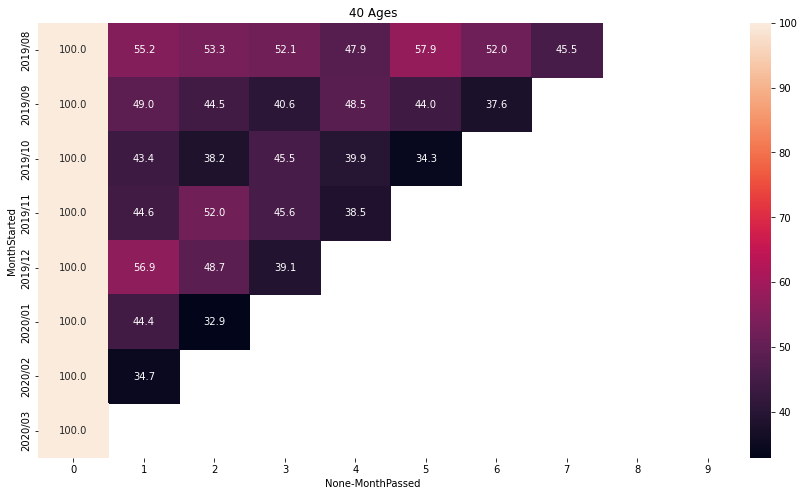

In [ ]:
female_dt = data[data['age_category'] == 40]
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('40 Ages')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

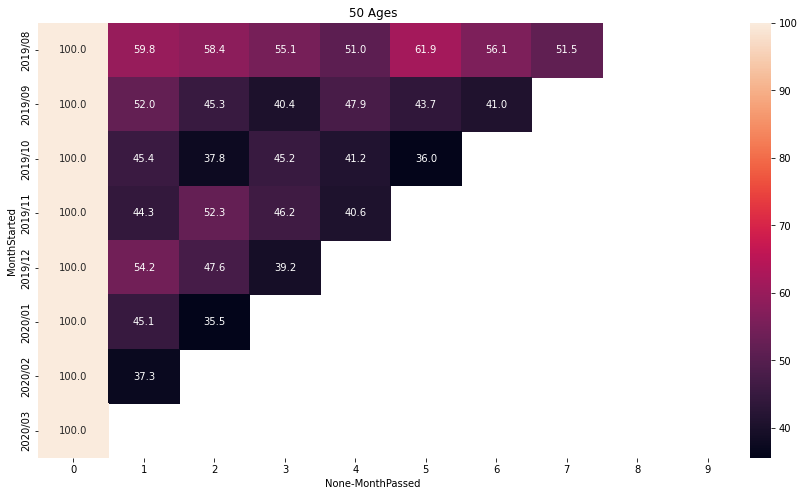

In [ ]:
female_dt = data[data['age_category'] == 50]
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('50 Ages')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

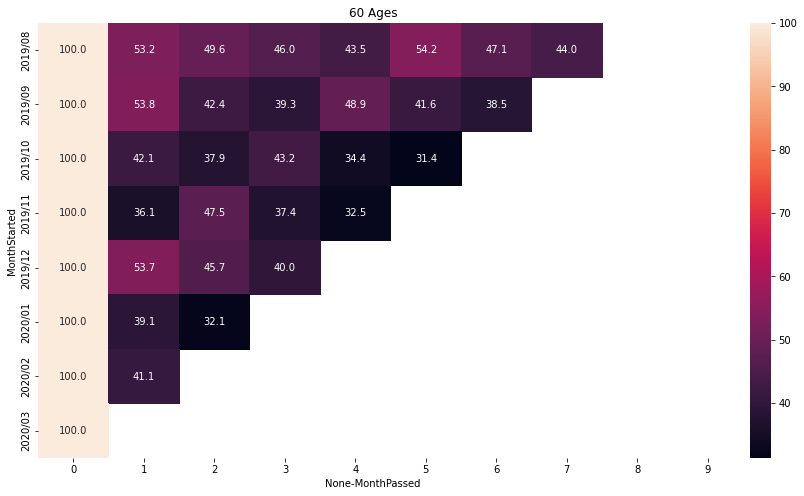

In [ ]:
female_dt = data[data['age_category'] == 60]
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('60 Ages')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

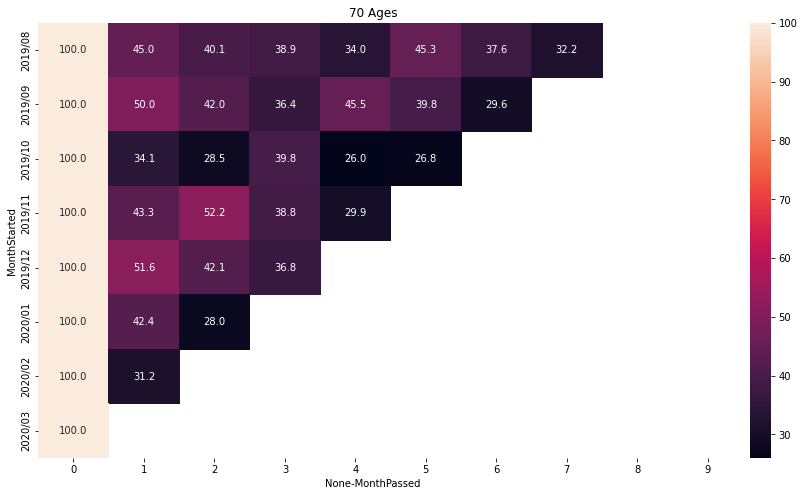

In [ ]:
female_dt = data[data['age_category'] == 70]
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()

female_df = female_df.pivot(index='MonthStarted', columns='MonthPassed')

female_cohort = female_df.div(female_df.iloc[:, 0], axis=0) * 100
female_cohort = female_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('70 Ages')
sns.heatmap(female_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

# 재구매 lineplot으로 보기

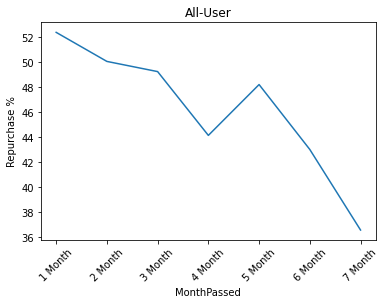

In [ ]:
female_group = data.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()
female_df

femonth0 = female_df[female_df['MonthPassed'] == 0]['customer_id']
femonth1.reset_index(drop=True, inplace = True)
femonth1 = female_df[female_df['MonthPassed'] == 1]['customer_id']
femonth1.reset_index(drop=True, inplace = True)
femonth2 = female_df[female_df['MonthPassed'] == 2]['customer_id']
femonth2.reset_index(drop=True, inplace = True)
femonth3 = female_df[female_df['MonthPassed'] == 3]['customer_id']
femonth3.reset_index(drop=True, inplace = True)
femonth4 = female_df[female_df['MonthPassed'] == 4]['customer_id']
femonth4.reset_index(drop=True, inplace = True)
femonth5 = female_df[female_df['MonthPassed'] == 5]['customer_id']
femonth5.reset_index(drop=True, inplace = True)
femonth6 = female_df[female_df['MonthPassed'] == 6]['customer_id']
femonth6.reset_index(drop=True, inplace = True)
femonth7 = female_df[female_df['MonthPassed'] == 7]['customer_id']
femonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

fmonthPassed = []

fmonthPassed.append((femonth1.div(femonth0) * 100).mean())
fmonthPassed.append((femonth2.div(femonth0) * 100).mean())
fmonthPassed.append((femonth3.div(femonth0) * 100).mean())
fmonthPassed.append((femonth4.div(femonth0) * 100).mean())
fmonthPassed.append((femonth5.div(femonth0) * 100).mean())
fmonthPassed.append((femonth6.div(femonth0) * 100).mean())
fmonthPassed.append((femonth7.div(femonth0) * 100).mean())

monthDate = pd.Series(monthDate)
fmonthPassed = pd.Series(fmonthPassed)
fremonth = pd.concat([fmonthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = fremonth[0], x = fremonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title('All-User')
plt.xticks(rotation=45)
plt.show()

## 성별

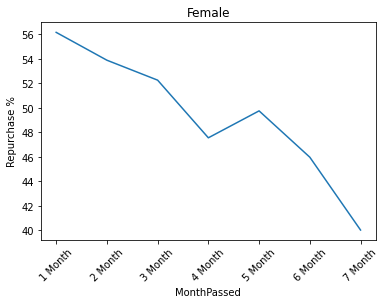

In [ ]:
# 여성 그룹
female_dt = data[data['gender'] == 'female']
female_group = female_dt.groupby(['MonthStarted', 'MonthPassed'])
female_df = female_group['customer_id'].apply(get_unique_no).reset_index()
female_df

femonth0 = female_df[female_df['MonthPassed'] == 0]['customer_id']
femonth1.reset_index(drop=True, inplace = True)
femonth1 = female_df[female_df['MonthPassed'] == 1]['customer_id']
femonth1.reset_index(drop=True, inplace = True)
femonth2 = female_df[female_df['MonthPassed'] == 2]['customer_id']
femonth2.reset_index(drop=True, inplace = True)
femonth3 = female_df[female_df['MonthPassed'] == 3]['customer_id']
femonth3.reset_index(drop=True, inplace = True)
femonth4 = female_df[female_df['MonthPassed'] == 4]['customer_id']
femonth4.reset_index(drop=True, inplace = True)
femonth5 = female_df[female_df['MonthPassed'] == 5]['customer_id']
femonth5.reset_index(drop=True, inplace = True)
femonth6 = female_df[female_df['MonthPassed'] == 6]['customer_id']
femonth6.reset_index(drop=True, inplace = True)
femonth7 = female_df[female_df['MonthPassed'] == 7]['customer_id']
femonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

fmonthPassed = []

fmonthPassed.append((femonth1.div(femonth0) * 100).mean())
fmonthPassed.append((femonth2.div(femonth0) * 100).mean())
fmonthPassed.append((femonth3.div(femonth0) * 100).mean())
fmonthPassed.append((femonth4.div(femonth0) * 100).mean())
fmonthPassed.append((femonth5.div(femonth0) * 100).mean())
fmonthPassed.append((femonth6.div(femonth0) * 100).mean())
fmonthPassed.append((femonth7.div(femonth0) * 100).mean())

monthDate = pd.Series(monthDate)
fmonthPassed = pd.Series(fmonthPassed)
fremonth = pd.concat([fmonthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = fremonth[0], x = fremonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title('Female')
plt.xticks(rotation=45)
plt.show()

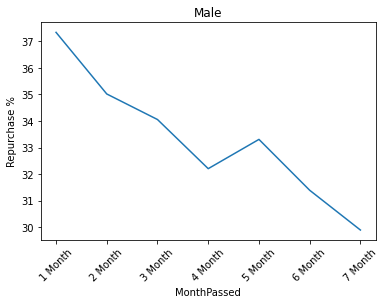

In [ ]:
# 남성 그룹
male_dt = data[data['gender'] == 'male']
male_group = male_dt.groupby(['MonthStarted', 'MonthPassed'])
male_df = male_group['customer_id'].apply(get_unique_no).reset_index()
male_df

month0 = male_df[male_df['MonthPassed'] == 0]['customer_id']
month0.reset_index(drop=True, inplace = True)
month1 = male_df[male_df['MonthPassed'] == 1]['customer_id']
month1.reset_index(drop=True, inplace = True)
month2 = male_df[male_df['MonthPassed'] == 2]['customer_id']
month2.reset_index(drop=True, inplace = True)
month3 = male_df[male_df['MonthPassed'] == 3]['customer_id']
month3.reset_index(drop=True, inplace = True)
month4 = male_df[male_df['MonthPassed'] == 4]['customer_id']
month4.reset_index(drop=True, inplace = True)
month5 = male_df[male_df['MonthPassed'] == 5]['customer_id']
month5.reset_index(drop=True, inplace = True)
month6 = male_df[male_df['MonthPassed'] == 6]['customer_id']
month6.reset_index(drop=True, inplace = True)
month7 = male_df[male_df['MonthPassed'] == 7]['customer_id']
month7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

monthPassed = []

monthPassed.append((month1.div(month0) * 100).mean())
monthPassed.append((month2.div(month0) * 100).mean())
monthPassed.append((month3.div(month0) * 100).mean())
monthPassed.append((month4.div(month0) * 100).mean())
monthPassed.append((month5.div(month0) * 100).mean())
monthPassed.append((month6.div(month0) * 100).mean())
monthPassed.append((month7.div(month0) * 100).mean())

monthDate = pd.Series(monthDate)
monthPassed = pd.Series(monthPassed)
remonth = pd.concat([monthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = remonth[0], x = remonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title('Male')
plt.xticks(rotation=45)
plt.show()

## 연령

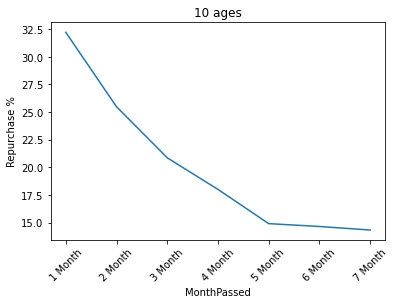

In [ ]:
# 10대
man_dt = data[data['age_category'] == 10]
man_group = man_dt.groupby(['MonthStarted', 'MonthPassed'])
man_df = man_group['customer_id'].apply(get_unique_no).reset_index()
man_df

mmonth0 = man_df[man_df['MonthPassed'] == 0]['customer_id']
mmonth0.reset_index(drop=True, inplace = True)
mmonth1 = man_df[man_df['MonthPassed'] == 1]['customer_id']
mmonth1.reset_index(drop=True, inplace = True)
mmonth2 = man_df[man_df['MonthPassed'] == 2]['customer_id']
mmonth2.reset_index(drop=True, inplace = True)
mmonth3 = man_df[man_df['MonthPassed'] == 3]['customer_id']
mmonth3.reset_index(drop=True, inplace = True)
mmonth4 = man_df[man_df['MonthPassed'] == 4]['customer_id']
mmonth4.reset_index(drop=True, inplace = True)
mmonth5 = man_df[man_df['MonthPassed'] == 5]['customer_id']
mmonth5.reset_index(drop=True, inplace = True)
mmonth6 = man_df[man_df['MonthPassed'] == 6]['customer_id']
mmonth6.reset_index(drop=True, inplace = True)
mmonth7 = man_df[man_df['MonthPassed'] == 7]['customer_id']
mmonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

monthPassed = []

monthPassed.append((mmonth1.div(mmonth0) * 100).mean())
monthPassed.append((mmonth2.div(mmonth0) * 100).mean())
monthPassed.append((mmonth3.div(mmonth0) * 100).mean())
monthPassed.append((mmonth4.div(mmonth0) * 100).mean())
monthPassed.append((mmonth5.div(mmonth0) * 100).mean())
monthPassed.append((mmonth6.div(mmonth0) * 100).mean())
monthPassed.append((mmonth7.div(mmonth0) * 100).mean())

monthDate = pd.Series(monthDate)
monthPassed = pd.Series(monthPassed)
remonth = pd.concat([monthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = remonth[0], x = remonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title("10 ages")
plt.xticks(rotation=45)
plt.show()

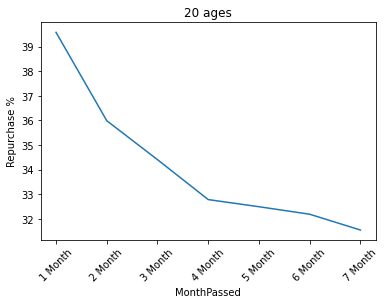

In [ ]:
# 20대
man_dt = data[data['age_category'] == 20]
man_group = man_dt.groupby(['MonthStarted', 'MonthPassed'])
man_df = man_group['customer_id'].apply(get_unique_no).reset_index()
man_df

mmonth0 = man_df[man_df['MonthPassed'] == 0]['customer_id']
mmonth0.reset_index(drop=True, inplace = True)
mmonth1 = man_df[man_df['MonthPassed'] == 1]['customer_id']
mmonth1.reset_index(drop=True, inplace = True)
mmonth2 = man_df[man_df['MonthPassed'] == 2]['customer_id']
mmonth2.reset_index(drop=True, inplace = True)
mmonth3 = man_df[man_df['MonthPassed'] == 3]['customer_id']
mmonth3.reset_index(drop=True, inplace = True)
mmonth4 = man_df[man_df['MonthPassed'] == 4]['customer_id']
mmonth4.reset_index(drop=True, inplace = True)
mmonth5 = man_df[man_df['MonthPassed'] == 5]['customer_id']
mmonth5.reset_index(drop=True, inplace = True)
mmonth6 = man_df[man_df['MonthPassed'] == 6]['customer_id']
mmonth6.reset_index(drop=True, inplace = True)
mmonth7 = man_df[man_df['MonthPassed'] == 7]['customer_id']
mmonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

monthPassed = []

monthPassed.append((mmonth1.div(mmonth0) * 100).mean())
monthPassed.append((mmonth2.div(mmonth0) * 100).mean())
monthPassed.append((mmonth3.div(mmonth0) * 100).mean())
monthPassed.append((mmonth4.div(mmonth0) * 100).mean())
monthPassed.append((mmonth5.div(mmonth0) * 100).mean())
monthPassed.append((mmonth6.div(mmonth0) * 100).mean())
monthPassed.append((mmonth7.div(mmonth0) * 100).mean())

monthDate = pd.Series(monthDate)
monthPassed = pd.Series(monthPassed)
remonth = pd.concat([monthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = remonth[0], x = remonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title("20 ages")
plt.xticks(rotation=45)
plt.show()

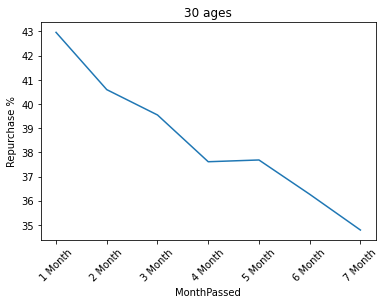

In [ ]:
# 30대
man_dt = data[data['age_category'] == 30]
man_group = man_dt.groupby(['MonthStarted', 'MonthPassed'])
man_df = man_group['customer_id'].apply(get_unique_no).reset_index()
man_df

mmonth0 = man_df[man_df['MonthPassed'] == 0]['customer_id']
mmonth0.reset_index(drop=True, inplace = True)
mmonth1 = man_df[man_df['MonthPassed'] == 1]['customer_id']
mmonth1.reset_index(drop=True, inplace = True)
mmonth2 = man_df[man_df['MonthPassed'] == 2]['customer_id']
mmonth2.reset_index(drop=True, inplace = True)
mmonth3 = man_df[man_df['MonthPassed'] == 3]['customer_id']
mmonth3.reset_index(drop=True, inplace = True)
mmonth4 = man_df[man_df['MonthPassed'] == 4]['customer_id']
mmonth4.reset_index(drop=True, inplace = True)
mmonth5 = man_df[man_df['MonthPassed'] == 5]['customer_id']
mmonth5.reset_index(drop=True, inplace = True)
mmonth6 = man_df[man_df['MonthPassed'] == 6]['customer_id']
mmonth6.reset_index(drop=True, inplace = True)
mmonth7 = man_df[man_df['MonthPassed'] == 7]['customer_id']
mmonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

monthPassed = []

monthPassed.append((mmonth1.div(mmonth0) * 100).mean())
monthPassed.append((mmonth2.div(mmonth0) * 100).mean())
monthPassed.append((mmonth3.div(mmonth0) * 100).mean())
monthPassed.append((mmonth4.div(mmonth0) * 100).mean())
monthPassed.append((mmonth5.div(mmonth0) * 100).mean())
monthPassed.append((mmonth6.div(mmonth0) * 100).mean())
monthPassed.append((mmonth7.div(mmonth0) * 100).mean())

monthDate = pd.Series(monthDate)
monthPassed = pd.Series(monthPassed)
remonth = pd.concat([monthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = remonth[0], x = remonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title("30 ages")
plt.xticks(rotation=45)
plt.show()

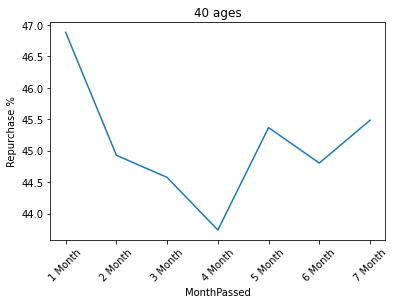

In [ ]:
# 40대
man_dt = data[data['age_category'] == 40]
man_group = man_dt.groupby(['MonthStarted', 'MonthPassed'])
man_df = man_group['customer_id'].apply(get_unique_no).reset_index()
man_df

mmonth0 = man_df[man_df['MonthPassed'] == 0]['customer_id']
mmonth0.reset_index(drop=True, inplace = True)
mmonth1 = man_df[man_df['MonthPassed'] == 1]['customer_id']
mmonth1.reset_index(drop=True, inplace = True)
mmonth2 = man_df[man_df['MonthPassed'] == 2]['customer_id']
mmonth2.reset_index(drop=True, inplace = True)
mmonth3 = man_df[man_df['MonthPassed'] == 3]['customer_id']
mmonth3.reset_index(drop=True, inplace = True)
mmonth4 = man_df[man_df['MonthPassed'] == 4]['customer_id']
mmonth4.reset_index(drop=True, inplace = True)
mmonth5 = man_df[man_df['MonthPassed'] == 5]['customer_id']
mmonth5.reset_index(drop=True, inplace = True)
mmonth6 = man_df[man_df['MonthPassed'] == 6]['customer_id']
mmonth6.reset_index(drop=True, inplace = True)
mmonth7 = man_df[man_df['MonthPassed'] == 7]['customer_id']
mmonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

monthPassed = []

monthPassed.append((mmonth1.div(mmonth0) * 100).mean())
monthPassed.append((mmonth2.div(mmonth0) * 100).mean())
monthPassed.append((mmonth3.div(mmonth0) * 100).mean())
monthPassed.append((mmonth4.div(mmonth0) * 100).mean())
monthPassed.append((mmonth5.div(mmonth0) * 100).mean())
monthPassed.append((mmonth6.div(mmonth0) * 100).mean())
monthPassed.append((mmonth7.div(mmonth0) * 100).mean())

monthDate = pd.Series(monthDate)
monthPassed = pd.Series(monthPassed)
remonth = pd.concat([monthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = remonth[0], x = remonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title("40 ages")
plt.xticks(rotation=45)
plt.show()

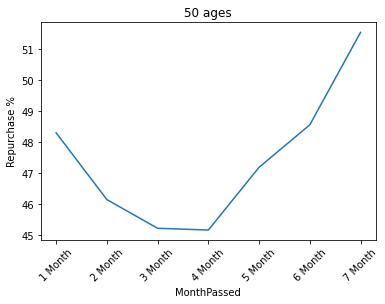

In [ ]:
# 50대
man_dt = data[data['age_category'] == 50]
man_group = man_dt.groupby(['MonthStarted', 'MonthPassed'])
man_df = man_group['customer_id'].apply(get_unique_no).reset_index()
man_df

mmonth0 = man_df[man_df['MonthPassed'] == 0]['customer_id']
mmonth0.reset_index(drop=True, inplace = True)
mmonth1 = man_df[man_df['MonthPassed'] == 1]['customer_id']
mmonth1.reset_index(drop=True, inplace = True)
mmonth2 = man_df[man_df['MonthPassed'] == 2]['customer_id']
mmonth2.reset_index(drop=True, inplace = True)
mmonth3 = man_df[man_df['MonthPassed'] == 3]['customer_id']
mmonth3.reset_index(drop=True, inplace = True)
mmonth4 = man_df[man_df['MonthPassed'] == 4]['customer_id']
mmonth4.reset_index(drop=True, inplace = True)
mmonth5 = man_df[man_df['MonthPassed'] == 5]['customer_id']
mmonth5.reset_index(drop=True, inplace = True)
mmonth6 = man_df[man_df['MonthPassed'] == 6]['customer_id']
mmonth6.reset_index(drop=True, inplace = True)
mmonth7 = man_df[man_df['MonthPassed'] == 7]['customer_id']
mmonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

monthPassed = []

monthPassed.append((mmonth1.div(mmonth0) * 100).mean())
monthPassed.append((mmonth2.div(mmonth0) * 100).mean())
monthPassed.append((mmonth3.div(mmonth0) * 100).mean())
monthPassed.append((mmonth4.div(mmonth0) * 100).mean())
monthPassed.append((mmonth5.div(mmonth0) * 100).mean())
monthPassed.append((mmonth6.div(mmonth0) * 100).mean())
monthPassed.append((mmonth7.div(mmonth0) * 100).mean())

monthDate = pd.Series(monthDate)
monthPassed = pd.Series(monthPassed)
remonth = pd.concat([monthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = remonth[0], x = remonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title("50 ages")
plt.xticks(rotation=45)
plt.show()

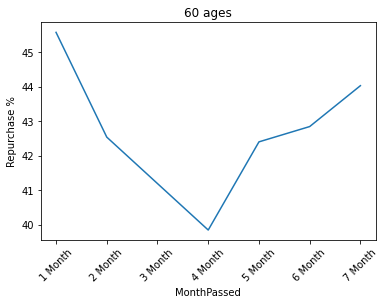

In [ ]:
# 60대
man_dt = data[data['age_category'] == 60]
man_group = man_dt.groupby(['MonthStarted', 'MonthPassed'])
man_df = man_group['customer_id'].apply(get_unique_no).reset_index()
man_df

mmonth0 = man_df[man_df['MonthPassed'] == 0]['customer_id']
mmonth0.reset_index(drop=True, inplace = True)
mmonth1 = man_df[man_df['MonthPassed'] == 1]['customer_id']
mmonth1.reset_index(drop=True, inplace = True)
mmonth2 = man_df[man_df['MonthPassed'] == 2]['customer_id']
mmonth2.reset_index(drop=True, inplace = True)
mmonth3 = man_df[man_df['MonthPassed'] == 3]['customer_id']
mmonth3.reset_index(drop=True, inplace = True)
mmonth4 = man_df[man_df['MonthPassed'] == 4]['customer_id']
mmonth4.reset_index(drop=True, inplace = True)
mmonth5 = man_df[man_df['MonthPassed'] == 5]['customer_id']
mmonth5.reset_index(drop=True, inplace = True)
mmonth6 = man_df[man_df['MonthPassed'] == 6]['customer_id']
mmonth6.reset_index(drop=True, inplace = True)
mmonth7 = man_df[man_df['MonthPassed'] == 7]['customer_id']
mmonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

monthPassed = []

monthPassed.append((mmonth1.div(mmonth0) * 100).mean())
monthPassed.append((mmonth2.div(mmonth0) * 100).mean())
monthPassed.append((mmonth3.div(mmonth0) * 100).mean())
monthPassed.append((mmonth4.div(mmonth0) * 100).mean())
monthPassed.append((mmonth5.div(mmonth0) * 100).mean())
monthPassed.append((mmonth6.div(mmonth0) * 100).mean())
monthPassed.append((mmonth7.div(mmonth0) * 100).mean())

monthDate = pd.Series(monthDate)
monthPassed = pd.Series(monthPassed)
remonth = pd.concat([monthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = remonth[0], x = remonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title("60 ages")
plt.xticks(rotation=45)
plt.show()

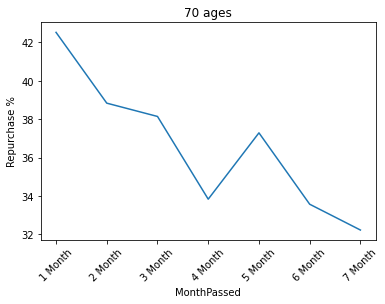

In [ ]:
# 70대
man_dt = data[data['age_category'] == 70]
man_group = man_dt.groupby(['MonthStarted', 'MonthPassed'])
man_df = man_group['customer_id'].apply(get_unique_no).reset_index()
man_df

mmonth0 = man_df[man_df['MonthPassed'] == 0]['customer_id']
mmonth0.reset_index(drop=True, inplace = True)
mmonth1 = man_df[man_df['MonthPassed'] == 1]['customer_id']
mmonth1.reset_index(drop=True, inplace = True)
mmonth2 = man_df[man_df['MonthPassed'] == 2]['customer_id']
mmonth2.reset_index(drop=True, inplace = True)
mmonth3 = man_df[man_df['MonthPassed'] == 3]['customer_id']
mmonth3.reset_index(drop=True, inplace = True)
mmonth4 = man_df[man_df['MonthPassed'] == 4]['customer_id']
mmonth4.reset_index(drop=True, inplace = True)
mmonth5 = man_df[man_df['MonthPassed'] == 5]['customer_id']
mmonth5.reset_index(drop=True, inplace = True)
mmonth6 = man_df[man_df['MonthPassed'] == 6]['customer_id']
mmonth6.reset_index(drop=True, inplace = True)
mmonth7 = man_df[man_df['MonthPassed'] == 7]['customer_id']
mmonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

monthPassed = []

monthPassed.append((mmonth1.div(mmonth0) * 100).mean())
monthPassed.append((mmonth2.div(mmonth0) * 100).mean())
monthPassed.append((mmonth3.div(mmonth0) * 100).mean())
monthPassed.append((mmonth4.div(mmonth0) * 100).mean())
monthPassed.append((mmonth5.div(mmonth0) * 100).mean())
monthPassed.append((mmonth6.div(mmonth0) * 100).mean())
monthPassed.append((mmonth7.div(mmonth0) * 100).mean())

monthDate = pd.Series(monthDate)
monthPassed = pd.Series(monthPassed)
remonth = pd.concat([monthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = remonth[0], x = remonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Repurchase %', fontsize = 10)
plt.title("70 ages")
plt.xticks(rotation=45)
plt.show()

# Push 유지율

첫구매기준으로 Push on한 사람들

In [ ]:
push_ct = []
dt0 = data[data['MonthStarted'] == '2019-08']
dt0_0 = dt0[dt0['MonthPassed'] == 0]
push_ct.append(dt0_0[dt0_0['push_permission'] == 'True']['customer_id'].nunique())
dt0_1 = dt0[dt0['MonthPassed'] == 1]
push_ct.append(dt0_1[dt0_1['push_permission'] == 'True']['customer_id'].nunique())
dt0_2 = dt0[dt0['MonthPassed'] == 2]
push_ct.append(dt0_2[dt0_2['push_permission'] == 'True']['customer_id'].nunique())
dt0_3 = dt0[dt0['MonthPassed'] == 3]
push_ct.append(dt0_3[dt0_3['push_permission'] == 'True']['customer_id'].nunique())
dt0_4 = dt0[dt0['MonthPassed'] == 4]
push_ct.append(dt0_4[dt0_4['push_permission'] == 'True']['customer_id'].nunique())
dt0_5 = dt0[dt0['MonthPassed'] == 5]
push_ct.append(dt0_5[dt0_5['push_permission'] == 'True']['customer_id'].nunique())
dt0_6 = dt0[dt0['MonthPassed'] == 6]
push_ct.append(dt0_6[dt0_6['push_permission'] == 'True']['customer_id'].nunique())
dt0_7 = dt0[dt0['MonthPassed'] == 7]
push_ct.append(dt0_7[dt0_7['push_permission'] == 'True']['customer_id'].nunique())

dt1 = data[data['MonthStarted'] == '2019-09']
dt1_0 = dt1[dt1['MonthPassed'] == 0]
push_ct.append(dt1_0[dt1_0['push_permission'] == 'True']['customer_id'].nunique())
dt1_1 = dt1[dt1['MonthPassed'] == 1]
push_ct.append(dt1_1[dt1_1['push_permission'] == 'True']['customer_id'].nunique())
dt1_2 = dt1[dt1['MonthPassed'] == 2]
push_ct.append(dt1_2[dt1_2['push_permission'] == 'True']['customer_id'].nunique())
dt1_3 = dt1[dt1['MonthPassed'] == 3]
push_ct.append(dt1_3[dt1_3['push_permission'] == 'True']['customer_id'].nunique())
dt1_4 = dt1[dt1['MonthPassed'] == 4]
push_ct.append(dt1_4[dt1_4['push_permission'] == 'True']['customer_id'].nunique())
dt1_5 = dt1[dt1['MonthPassed'] == 5]
push_ct.append(dt1_5[dt1_5['push_permission'] == 'True']['customer_id'].nunique())
dt1_6 = dt1[dt1['MonthPassed'] == 6]
push_ct.append(dt1_6[dt1_6['push_permission'] == 'True']['customer_id'].nunique())

dt2 = data[data['MonthStarted'] == '2019-10']
dt2_0 = dt2[dt2['MonthPassed'] == 0]
push_ct.append(dt2_0[dt2_0['push_permission'] == 'True']['customer_id'].nunique())
dt2_1 = dt2[dt2['MonthPassed'] == 1]
push_ct.append(dt2_1[dt2_1['push_permission'] == 'True']['customer_id'].nunique())
dt2_2 = dt2[dt2['MonthPassed'] == 2]
push_ct.append(dt2_2[dt2_2['push_permission'] == 'True']['customer_id'].nunique())
dt2_3 = dt2[dt2['MonthPassed'] == 3]
push_ct.append(dt2_3[dt2_3['push_permission'] == 'True']['customer_id'].nunique())
dt2_4 = dt2[dt2['MonthPassed'] == 4]
push_ct.append(dt2_4[dt2_4['push_permission'] == 'True']['customer_id'].nunique())
dt2_5 = dt2[dt2['MonthPassed'] == 5]
push_ct.append(dt2_5[dt2_5['push_permission'] == 'True']['customer_id'].nunique())

dt3 = data[data['MonthStarted'] == '2019-11']
dt3_0 = dt3[dt3['MonthPassed'] == 0]
push_ct.append(dt3_0[dt3_0['push_permission'] == 'True']['customer_id'].nunique())
dt3_1 = dt3[dt3['MonthPassed'] == 1]
push_ct.append(dt3_1[dt3_1['push_permission'] == 'True']['customer_id'].nunique())
dt3_2 = dt3[dt3['MonthPassed'] == 2]
push_ct.append(dt3_2[dt3_2['push_permission'] == 'True']['customer_id'].nunique())
dt3_3 = dt3[dt3['MonthPassed'] == 3]
push_ct.append(dt3_3[dt3_3['push_permission'] == 'True']['customer_id'].nunique())
dt3_4 = dt3[dt3['MonthPassed'] == 4]
push_ct.append(dt3_4[dt3_4['push_permission'] == 'True']['customer_id'].nunique())

dt4 = data[data['MonthStarted'] == '2019-12']
dt4_0 = dt4[dt4['MonthPassed'] == 0]
push_ct.append(dt4_0[dt4_0['push_permission'] == 'True']['customer_id'].nunique())
dt4_1 = dt4[dt4['MonthPassed'] == 1]
push_ct.append(dt4_1[dt4_1['push_permission'] == 'True']['customer_id'].nunique())
dt4_2 = dt4[dt4['MonthPassed'] == 2]
push_ct.append(dt4_2[dt4_2['push_permission'] == 'True']['customer_id'].nunique())
dt4_3 = dt4[dt4['MonthPassed'] == 3]
push_ct.append(dt4_3[dt4_3['push_permission'] == 'True']['customer_id'].nunique())

dt5 = data[data['MonthStarted'] == '2020-01']
dt5_0 = dt5[dt5['MonthPassed'] == 0]
push_ct.append(dt5_0[dt5_0['push_permission'] == 'True']['customer_id'].nunique())
dt5_1 = dt5[dt5['MonthPassed'] == 1]
push_ct.append(dt5_1[dt5_1['push_permission'] == 'True']['customer_id'].nunique())
dt5_2 = dt5[dt5['MonthPassed'] == 2]
push_ct.append(dt5_2[dt5_2['push_permission'] == 'True']['customer_id'].nunique())

dt6 = data[data['MonthStarted'] == '2020-02']
dt6_0 = dt6[dt6['MonthPassed'] == 0]
push_ct.append(dt6_0[dt6_0['push_permission'] == 'True']['customer_id'].nunique())
dt6_1 = dt6[dt6['MonthPassed'] == 1]
push_ct.append(dt6_1[dt6_1['push_permission'] == 'True']['customer_id'].nunique())

dt7 = data[data['MonthStarted'] == '2020-03']
dt7_0 = dt7[dt7['MonthPassed'] == 0]
push_ct.append(dt7_0[dt7_0['push_permission'] == 'True']['customer_id'].nunique())

재구매 cohort에서 cohort_df생성한 상태에서 병합

In [ ]:
push_ct = pd.concat([cohort_df,push_ct], axis=1)
push_ct.rename(columns = {"0" : "push_on"}, inplace = True)
push_ct.drop(['customer_n'], axis=1, inplace=True)
push_ct

,MonthStarted,MonthPassed,0
0,2019-08,0,86314
1,2019-08,1,49498
2,2019-08,2,47397
3,2019-08,3,46047
4,2019-08,4,41992
5,2019-08,5,43996
6,2019-08,6,40652
7,2019-08,7,36432
8,2019-09,0,24797
9,2019-09,1,12321


heat-map으로 보기

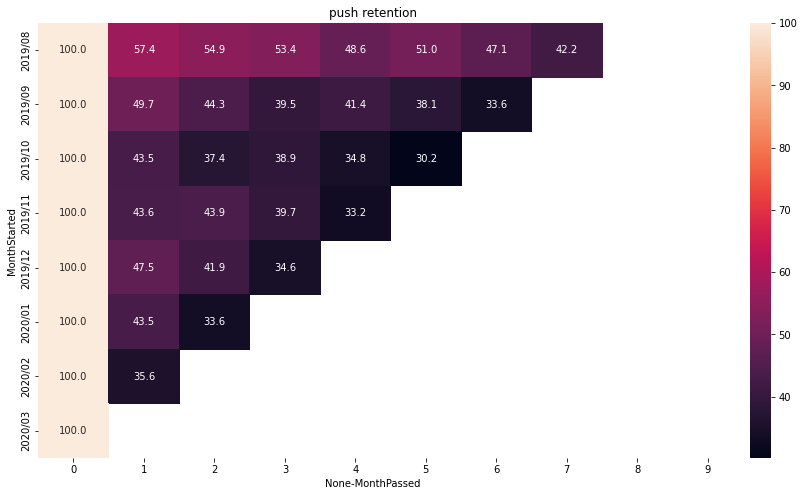

In [ ]:
push_df = push_ct.pivot(index='MonthStarted', columns='MonthPassed')

push_cohort = push_df.div(push_df.iloc[:, 0], axis=0) * 100
push_cohort = push_cohort.round(decimals=2)

xticks = np.arange(0, 10)
yticks = ['2019/08', '2019/09', '2019/10', '2019/11', '2019/12', '2020/01', '2020/02', '2020/03']

plt.figure(figsize = (15, 8))
plt.title('push retention')
sns.heatmap(push_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')

lineplot으로 보기

In [ ]:
push_ct.columns = ['MonthStarted', 'MonthPassed','push_on']
push_ct.head(3)

,MonthStarted,MonthPassed,push_on
0,2019-08,0,86314
1,2019-08,1,49498
2,2019-08,2,47397


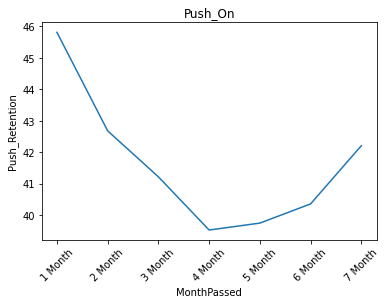

In [ ]:
femonth0 = push_ct[push_ct['MonthPassed'] == 0]['push_on']
femonth0.reset_index(drop=True, inplace = True)
femonth1 = push_ct[push_ct['MonthPassed'] == 1]['push_on']
femonth1.reset_index(drop=True, inplace = True)
femonth2 = push_ct[push_ct['MonthPassed'] == 2]['push_on']
femonth2.reset_index(drop=True, inplace = True)
femonth3 = push_ct[push_ct['MonthPassed'] == 3]['push_on']
femonth3.reset_index(drop=True, inplace = True)
femonth4 = push_ct[push_ct['MonthPassed'] == 4]['push_on']
femonth4.reset_index(drop=True, inplace = True)
femonth5 = push_ct[push_ct['MonthPassed'] == 5]['push_on']
femonth5.reset_index(drop=True, inplace = True)
femonth6 = push_ct[push_ct['MonthPassed'] == 6]['push_on']
femonth6.reset_index(drop=True, inplace = True)
femonth7 = push_ct[push_ct['MonthPassed'] == 7]['push_on']
femonth7.reset_index(drop=True, inplace = True)

monthDate = ['1 Month', '2 Month', '3 Month', '4 Month', '5 Month', '6 Month', '7 Month']

fmonthPassed = []

fmonthPassed.append((femonth1.div(femonth0) * 100).mean())
fmonthPassed.append((femonth2.div(femonth0) * 100).mean())
fmonthPassed.append((femonth3.div(femonth0) * 100).mean())
fmonthPassed.append((femonth4.div(femonth0) * 100).mean())
fmonthPassed.append((femonth5.div(femonth0) * 100).mean())
fmonthPassed.append((femonth6.div(femonth0) * 100).mean())
fmonthPassed.append((femonth7.div(femonth0) * 100).mean())

monthDate = pd.Series(monthDate)
fmonthPassed = pd.Series(fmonthPassed)
fremonth = pd.concat([fmonthPassed, monthDate], axis = 1)
ax = sns.lineplot(y = fremonth[0], x = fremonth[1], data = fremonth)
ax.set_xlabel('MonthPassed', fontsize = 10)
ax.set_ylabel('Push_Retention', fontsize = 10)
plt.title('Push_On')
plt.xticks(rotation=45)
plt.show()

# 재구매 데이터와 고객데이터 병합

In [ ]:
cust = data.drop_duplicates(['customer_id'], keep = 'first') # 고객중복제거
rebuy.reset_index(drop=False, inplace = True) # 인덱스 부여
demo = pd.merge(rebuy, cust, on = 'customer_id', how = 'inner') # 고객 데이터와 재구매 데이터 병합
demo.head()

In [ ]:
demo.columns

In [ ]:
demo = demo[['customer_id', 'first', 'last', 'buy_ct', 'term', 'cycle','push_permission', 'gender', 'is_foreigner',
       'birthday', 'age', 'age_category', 'sign_up_date']]
demo.head(10)

# RFM


R : 최근 방문일

- recency = 최근


In [ ]:
# 최근 방문일
## 각 고객별 최근방문일을 알아보자.
recency_df = pd.DataFrame(data.groupby('customer_id',as_index=False)['created_at'].max()) ## 아이디로 그룹화 한다음 최근방문일을 구해야 하므로 송장날짜에 max를 적용한다.
recency_df.columns = ['customer_id', 'LastPurchaseDate']

In [ ]:

# 최근 방문일로부터 얼마나 지났는지 
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (data['created_at'].max() - x).days)


recency_df.drop(columns =['LastPurchaseDate'],inplace = True )

F : 결제 빈도

- frequency = 고객 ID groupby후 created_at을 카운트


In [ ]:
## 각 고객별 구매횟수를 알아보자.
frequency_df = data.loc[:,('customer_id','counts')]
frequency_df

,customer_id,counts
0,207317,13
1,95246,20
2,208074,47
3,15552,24
4,511595,3
...,...,...
5623805,434398,136
5623806,481515,40
5623807,298192,13
5623808,430962,18


M : 기업에 대한 고객의 금전적 이익

- monetary = 고객 ID groupby후 post_discount의 합

In [ ]:
money = pd.DataFrame(data.groupby('customer_id',as_index=False)['post_discount'].sum())
money

,customer_id,post_discount
0,1,18960
1,10,22590
2,100,477525
3,1000,27300
4,10000,27150
...,...,...
544916,99995,114840
544917,99996,2861400
544918,99997,48230
544919,99998,14880


In [ ]:
## 데이터 병합
rfm_df = pd.concat([money,recency_df],axis=1) # money에 recency합치기
rfm = pd.concat([rfm_df,frequency_df],axis=1) # frequency합치기
rfm.columns = ['monetary','recency','frequency'] # 열의 이름 바꿔주기
rfm['recency'] = pd.to_datetime(rfm['recency']) # recency파일 날짜 형식으로 바꾸기
rfm['recency'] = rfm['recency'].dt.to_period(freq='M') # recency에 년-월 형식으로만 나올수 있게 하기
rfm

In [ ]:
# min_max 스케일링
from sklearn.preprocessing import minmax_scale

## 최근성: 숫자가 작을수록 좋음
# 즉, 최근 구매일이 얼마 지나지 않은 고객이 더 점수가 높음

rfm['Recency'] = minmax_scale(rfm['Recency'], axis = 0, copy = True )
#행기준으로, 카피해서 만들기
rfm['Recency'] = 1 - rfm['Recency']  # 작은값이 좋기 때문에, 1에서 빼줌(반전)


rfm['Frequency'] = minmax_scale(rfm['Frequency'], axis = 0, copy = True )
rfm['Monetary'] = minmax_scale(rfm['Monetary'], axis = 0, copy = True )


# 점수화하기
# score
rfm['Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']


# score 에 minmax_scale 적용
# 100을 곱해서 100점 만점으로 스케일링

rfm['Score'] = minmax_scale(rfm['Score'], axis = 0, copy = True) * 100

rfm['Score'] = round(rfm['Score'], 0)
rfm.head(3)

# LTV

m: post_ 평균

c: total_promotion의 평균 

r: 월별 재구매율 평균률

i: discount_rate (캐쉬백은 빼고)

ac:  첫 방문 했을 때 구매한 금액



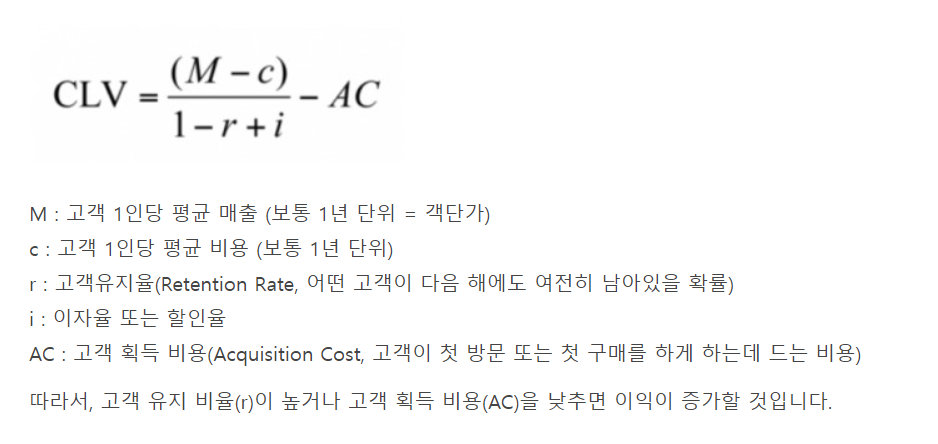

In [ ]:
data.head(3)

In [ ]:
# m: post_discount 평균

pd.DataFrame(data.groupby('customer_id')['post_discount'].mean())

In [ ]:
# c: total_promotion의 평균


pd.DataFrame(data.groupby('customer_id')['total_promotion'].mean())

In [ ]:
# r: 월별 재구매율 평균률



In [ ]:
# i: discount_rate (캐쉬백은 빼고)
# ac: 첫 방문 했을 때 구매한 금액




In [ ]:
# 다양한 평가지표

In [ ]:
# dau : 하루동안 방문한 사용자 수
data['year'] = data['created_at'].dt.year
data['month'] = data['created_at'].dt.month
data['day'] = data['created_at'].dt.day

dau = data.drop_duplicates(['customer_id','year','month','day'])
pd.DataFrame(mau.groupby(['year','month'])['count'].sum())

In [ ]:
# MAU = 한 달 동안 방문한 사용자 수
mau = data.drop_duplicates(['customer_id','year','month'])
pd.DataFrame(mau.groupby(['year','month'])['count'].sum())

In [ ]:
# 고착도(Stickiness)는 사용자들이 서비스로 얼마나 많이 돌아오는지 측정하는 지표입니다.
# 수치가 높을수록 많은 사용자들이 서비스에 돌아옵니다.
# Stickiness = (DAU / MAU) x 100
